<h1 style="font-size:2em">Projet 8 - Déployez un modèle dans le cloud</h1>

# Contexte

- **Start-up:** "Fruits!"
- **Objectif:** Application mobile qui permettrait prendre en photo un fruit et d'obtenir des informations 
- **Notebook alternant:** P8_Notebook_Linux_EMR_PySpark_V1.0.ipynb
    - Première approche dans un environnement AWS EMR
    - Servira de point de départ pour la suite
- **Données:** Images de fruits + labels associés

# Mes missions

- Compléter la chaîne de traitement de l'alternant
- Ne pas entrainer de modèle (utiliser un modèle préentrainé?)
- Le volume de données va augmenter très rapidement après la livraison de ce projet
    - Le script doit prendre compte de ca
    - Choisir entre AWS (EMR, S3, IAM) et Databricks pour l'instance
- Expliquer pas à pas le script PySpark complet
- Diffuser les poids du modèle Tensorflow sur les clusters (broadcast des “weights” du modèle)
    - On peut s'aider de ca: https://learn.microsoft.com/en-us/azure/databricks/_static/notebooks/deep-learning/keras-metadata.html
- Créer une étape de réduction de dimension de type PCA en PySpark 
- Respecter les contraintes du RGPD -> installation afin d’utiliser des serveurs situés sur le territoire européen 

# Livrables 

- Un notebook sur le cloud contenant les scripts en Pyspark exécutables 
- Les images du jeu de données initial 
- La sortie de la réduction de dimension (une matrice écrite sur un fichier CSV ou autre) 
    - Doit être disponible dans un espace de stockage sur le cloud.
- Support de présentation pour la soutenance, présentant :
    - Les différentes briques d'architecture choisies sur le cloud ;
    - Leur rôle dans l’architecture Big Data ;
    - La démarche de mise en oeuvre de l’environnement Big Data (EMR ou Databricks)
    - Les étapes de la chaîne de traitement PySpark.

# Présentation

- Rappel de la problématique et présentation du jeu de données (3 mn)
- Présentation du processus de création de l’environnement Big Data, S3 et EMR ou Databricks (6 mn)
- Présentation de la réalisation de la chaîne de traitement des images dans un environnement Big Data dans le cloud (6 mn)
- Démonstration d’exécution du script PYSpark sur le Cloud (2 mn)
- Synthèse et conclusion (3 mn)

# Référentiel d'évaluation

**Identifier les outils du cloud permettant de mettre en place un environnement Big Data:**
- **CE1:** Identifier les différentes briques d'architecture nécessaires pour la mise en place d'un environnement Big Data.
- **CE2:** Identifier les outils permettant de mettre en place l'environnement Big Data conforme aux normes RGPD 

**Utiliser les outils du cloud pour manipuler de la donnée dans un environnement Big Data:**
- **CE1:** Charger les fichiers de départ et ceux après transformation dans un espace de stockage cloud conforme à la RGPD
- **CE2** Executer les scripts en utilisant des machines dans le cloud.
- **CE3:** Réaliser un script qui permet d'écrire les sorties du programme directement dans l'espace de stockage cloud.

**Paralléliser des opérations de calcul avec Pyspark**

- **CE1:** Identifier les traitements critiques lors d'un passage à l'échelle en termes de volume de données.
- **CE2:** Veiller à ce que l’exploitation des données soit conforme au RGPD. Dans le cadre de ce projet : 
    - Les données sont stockées, et les traitements sont réalisés, sur des serveurs situés sur le territoire européen
- **CE3:** Développer les scripts s’appuyant sur Spark.
- **CE4:** S'assurer que toute la chaîne de traitement est exécutée dans le cloud.

# Prises de notes

**Pas d'entrainement du modèle:**
- On fera du transfert learning
- Nous allons récupérer l'avant dernière couche du modèle 
- On utilisera MobileNetV2
    - Rapide
    - Faible dimensionnalité de l'avant dernière couche du modèle (1,1,1280)

# Architecture dataset (fruits-360_dataset)

- Nombre total d'images: 90483
- Nombre images training: 67692 
- Nombre images test: 22688 
- Nombre de classes: 131
- Taille des images: 100X100

# Script PySpark (Local)

## A executer à chaque fois

http://localhost:4040

In [1]:
import logging, sys
import os
logging.disable(sys.maxsize)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

**Installation des packages nécéssaires:**

**Import des librairies**

In [2]:
import pandas as pd
from PIL import Image
import numpy as np
import io

import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from pyspark.sql import SparkSession

- On prend les 22688 du dossier Test et les met dans /data/Test1
- On cré un dossier Result qui contiendra les résultats du traitement

In [36]:
PATH = os.getcwd()
PATH_Data = os.path.join(PATH, 'data', 'Test1')
PATH_Result = os.path.join(PATH, 'data', 'Results')

print('PATH:        '+\
      PATH+'\nPATH_Data:   '+\
      PATH_Data+'\nPATH_Result: '+PATH_Result)

PATH:        /mnt/c/Users/Home/Desktop/OpenClassrooms/Projet8/Projet
PATH_Data:   /mnt/c/Users/Home/Desktop/OpenClassrooms/Projet8/Projet/data/Test1
PATH_Result: /mnt/c/Users/Home/Desktop/OpenClassrooms/Projet8/Projet/data/Results


**Création de la SparkSession:**
- Mon PC a 56gb, la mémoire que Spark aloue par défault est de 512 Mo -> J'augmente ca à 30gb)

In [3]:
spark = (SparkSession
             .builder
             .appName('P8') # Nom de l'application
             .master('local') # On se met en local
             .config("spark.sql.parquet.writeLegacyFormat", 'true') #Format parquet pour enregistrer nos résultats
             .getOrCreate() # Obtenir une session spark existante ou si aucune n'existe, en créer une nouvelle
)

23/10/11 05:11:05 WARN Utils: Your hostname, DESKTOP-UF7UQLD resolves to a loopback address: 127.0.1.1; using 172.31.184.138 instead (on interface eth0)
23/10/11 05:11:05 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
23/10/11 05:11:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/10/11 05:11:07 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


**Création de SparkContext**

In [4]:
sc = spark.sparkContext

**Affichage des infos de Spark en cours d'execution**

In [5]:
spark

**On charge les images en format binaire**
- On indique qu'on ne veut charger uniquement que des fichiers jpg
- On lui indique aussi de charger les objets inclus dans les sous dossiers

## Extraction des features et export sous forme de parquets

In [7]:
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

**On modifie l'objet "images" pour avoir un path + label**

In [8]:
from pyspark.sql.functions import rand

images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
random_images = images.orderBy(rand()).limit(5)
print(random_images.printSchema())
print(random_images.select('path','label').show(5,False))

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None


+---------------------------------------------------------------------------------------------------------+------------------+
|path                                                                                                     |label             |
+---------------------------------------------------------------------------------------------------------+------------------+
|file:/mnt/c/Users/Home/Desktop/OpenClassrooms/Projet8/Projet/data/Test1/Apple Golden 3/r_74_100.jpg      |Apple Golden 3    |
|file:/mnt/c/Users/Home/Desktop/OpenClassrooms/Projet8/Projet/data/Test1/Cherry Wax Black/228_100.jpg     |Cherry Wax Black  |
|file:/mnt/c/Users/Home/Desktop/OpenClassrooms/Projet8/Projet/data/Test1/Apricot/r_76_100.jpg             |Apricot           |
|file:/mnt/c/Users/Home/Desktop/OpenClassrooms/Projet8/Projet/data/Test1/Granadilla/60_100.jpg            |Granadilla        |
|file:/mnt/c/Users/Home/Desktop/OpenClassrooms/Projet8/Projet/data/Test1/Apple Red Yellow 2/r2_194_100.jpg|Appl

**Chargement modèle MobileNetV2 (préentrainé avec imagenet)**
https://towardsdatascience.com/review-mobilenetv2-light-weight-model-image-classification-8febb490e61c

In [9]:
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

**On supprime la dernières couche pour que la "nouvelle" derniere couche soit un (1,1,1280)**

In [10]:
new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

**On regarde a quoi il ressemble**

In [11]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

**On partage le modèle dans tout les noeuds du cluster:**
- Minimise la communication entre les noeuds et augmente les performances

In [12]:
brodcast_weights = sc.broadcast(new_model.get_weights())

**On cré une fonction model_fn():**
- Il charge le modèle préentrainé MobileNetV2
- Les poids sont non entrainables 
- On supprime la dernière couche
- On définit les poids du nouveau modèle en utilisant les poids diffusés

In [13]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

**On cré une fonction preprocess(content):**
- Redimensionne les images 100x100 en images 224x224
- Convertit les images en tableaux numpy 

In [14]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

**On cré une fonction featurize_series(model, content_series):**
- Prend en entrée un modèle et une série pandas d’images brutes (content_series)
- Applique la fonction preprocess()
- Utilise le modèle pour prédire les featires de chaque image dans le tableau numpy (preds)
- Aplati ces features en vecteurs pour faciliter leur stockage dans les DataFrames Spark (output)

In [15]:
def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

**On cré une fonction featurize_udf(content_series_iter):**
- **UDF = User-Defined function** (Utilise pandas pour manipuler les données dans Spark)
- **@pandas_udf("array-float"):** Cette UDF renvoie une sortie qui sera une liste de nombres à virgule flottante.
- Execute **model_fn()**
- Dans la boucle, on appelle la fonction **featurize_series()**

In [16]:
from pyspark.sql.pandas.functions import pandas_udf
from typing import Iterator, Tuple
import pandas as pd

@pandas_udf("array<float>")
def featurize_udf(content_series_iter: Iterator[pd.Series]) -> Iterator[pd.Series]:
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

**On va executer l'extraction de features sur nos images:** 
- **images.repartition(20):** Cette ligne répartit le DataFrame images en 20 partitions
- Retourne un DataFrame avec les chemins des images, leurs labels, et leurs caractéristiques extraites

In [18]:
features_df = images.sample(False, 1.0).repartition(20).select(col("path"),
                                                               col("label"),
                                                               featurize_udf("content").alias("features")
                                                              )

In [19]:
print(PATH_Result)

/mnt/c/Users/Home/Desktop/OpenClassrooms/Projet8/Projet/data/Results


**On enregistre les résultats de features_df dans 20 parquets**

In [20]:
features_df.write.mode("overwrite").parquet(PATH_Result)

35/35 [==============================] - 18s 495ms/step


**Voici les résultats (Intel I7 10700K)**

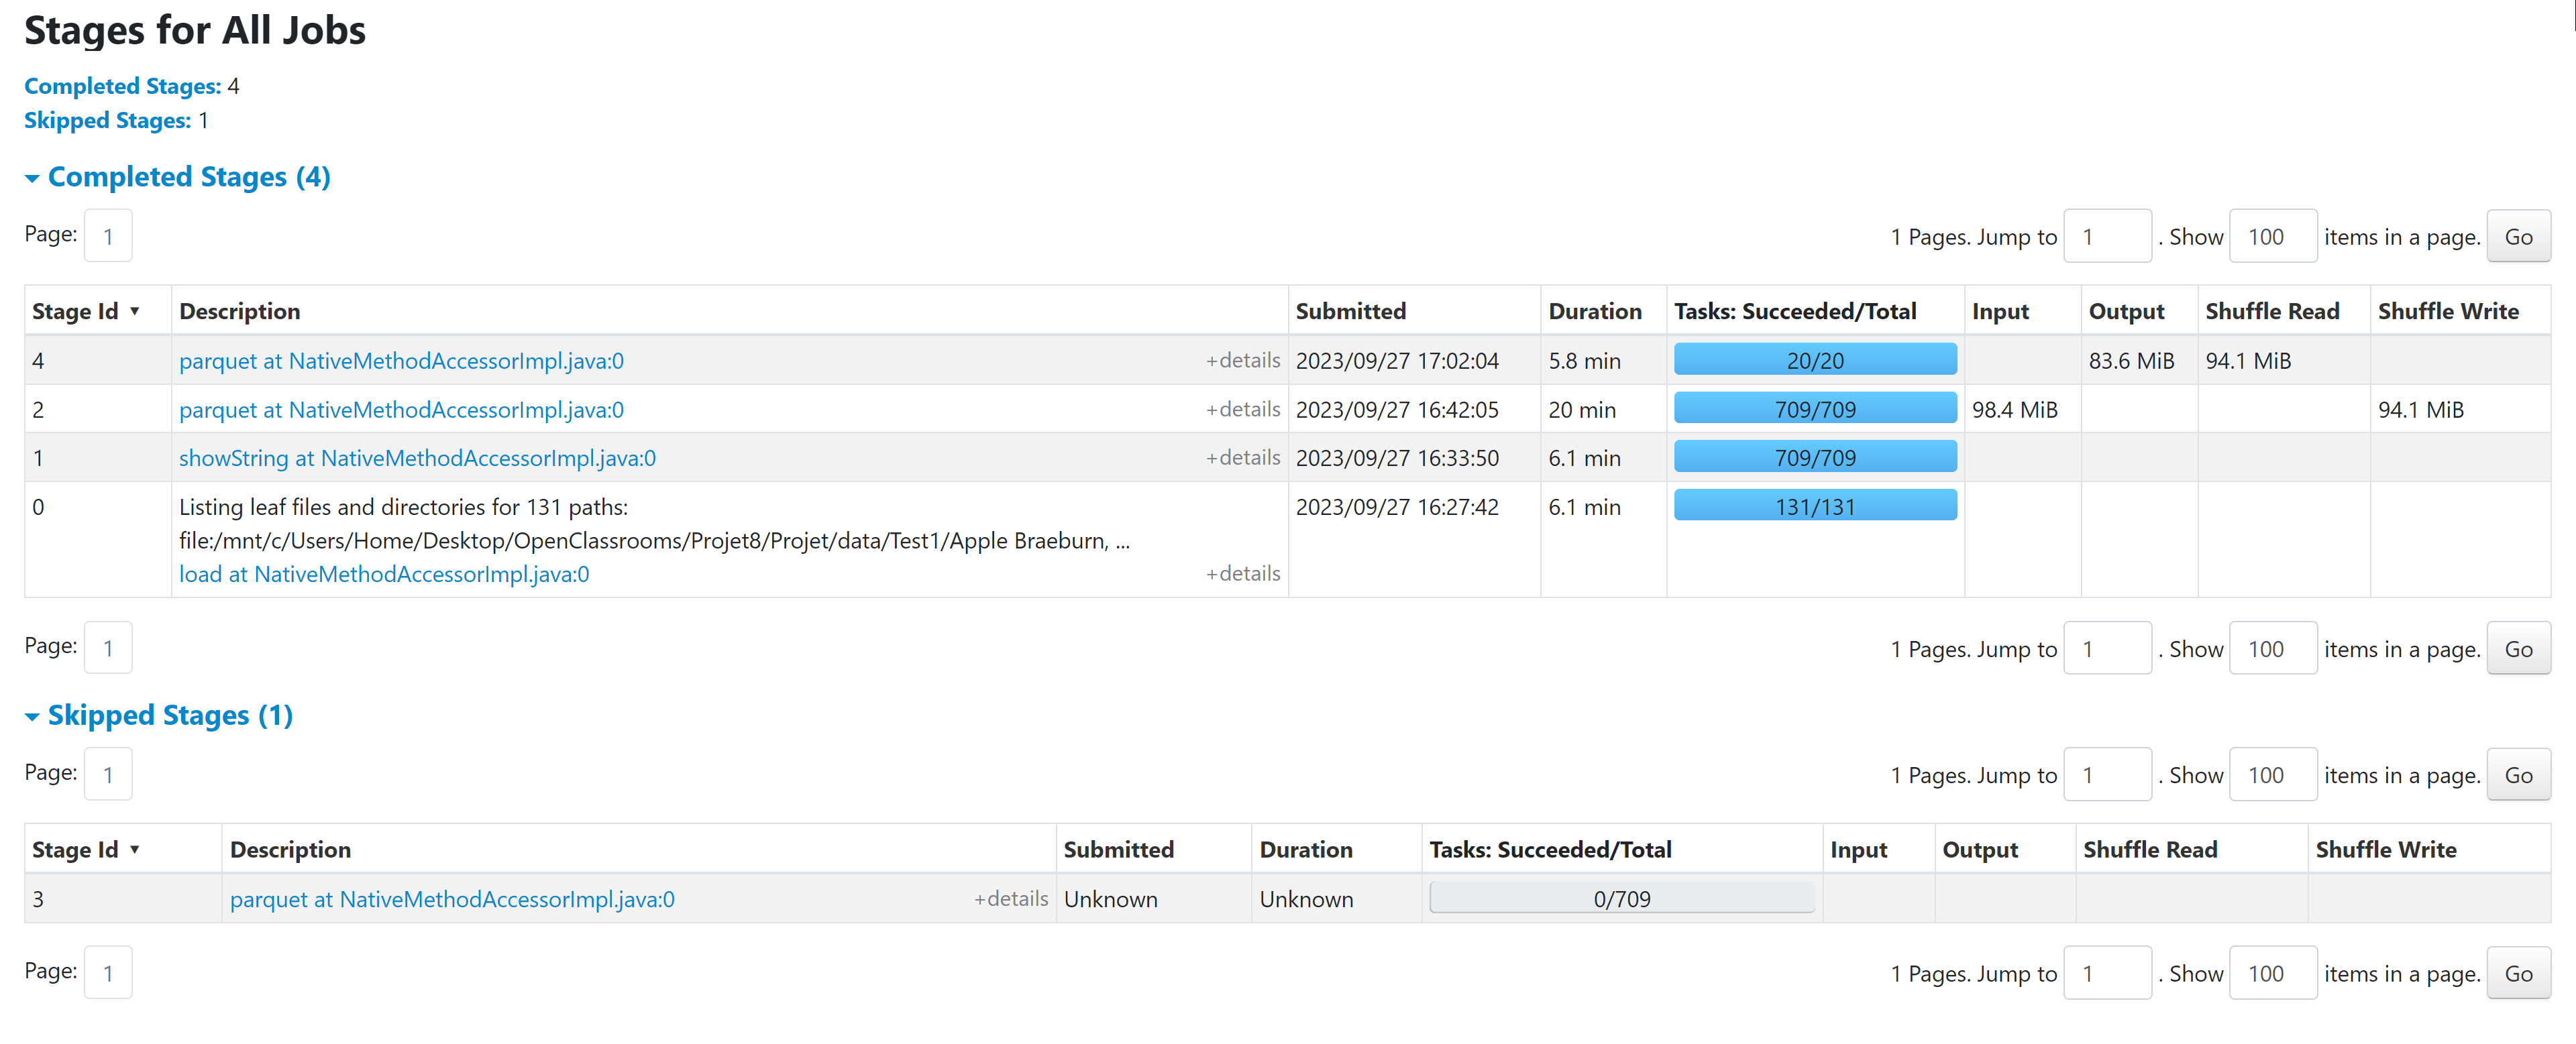

**Stage0:**
- parallelize
- mapPartitions
- map

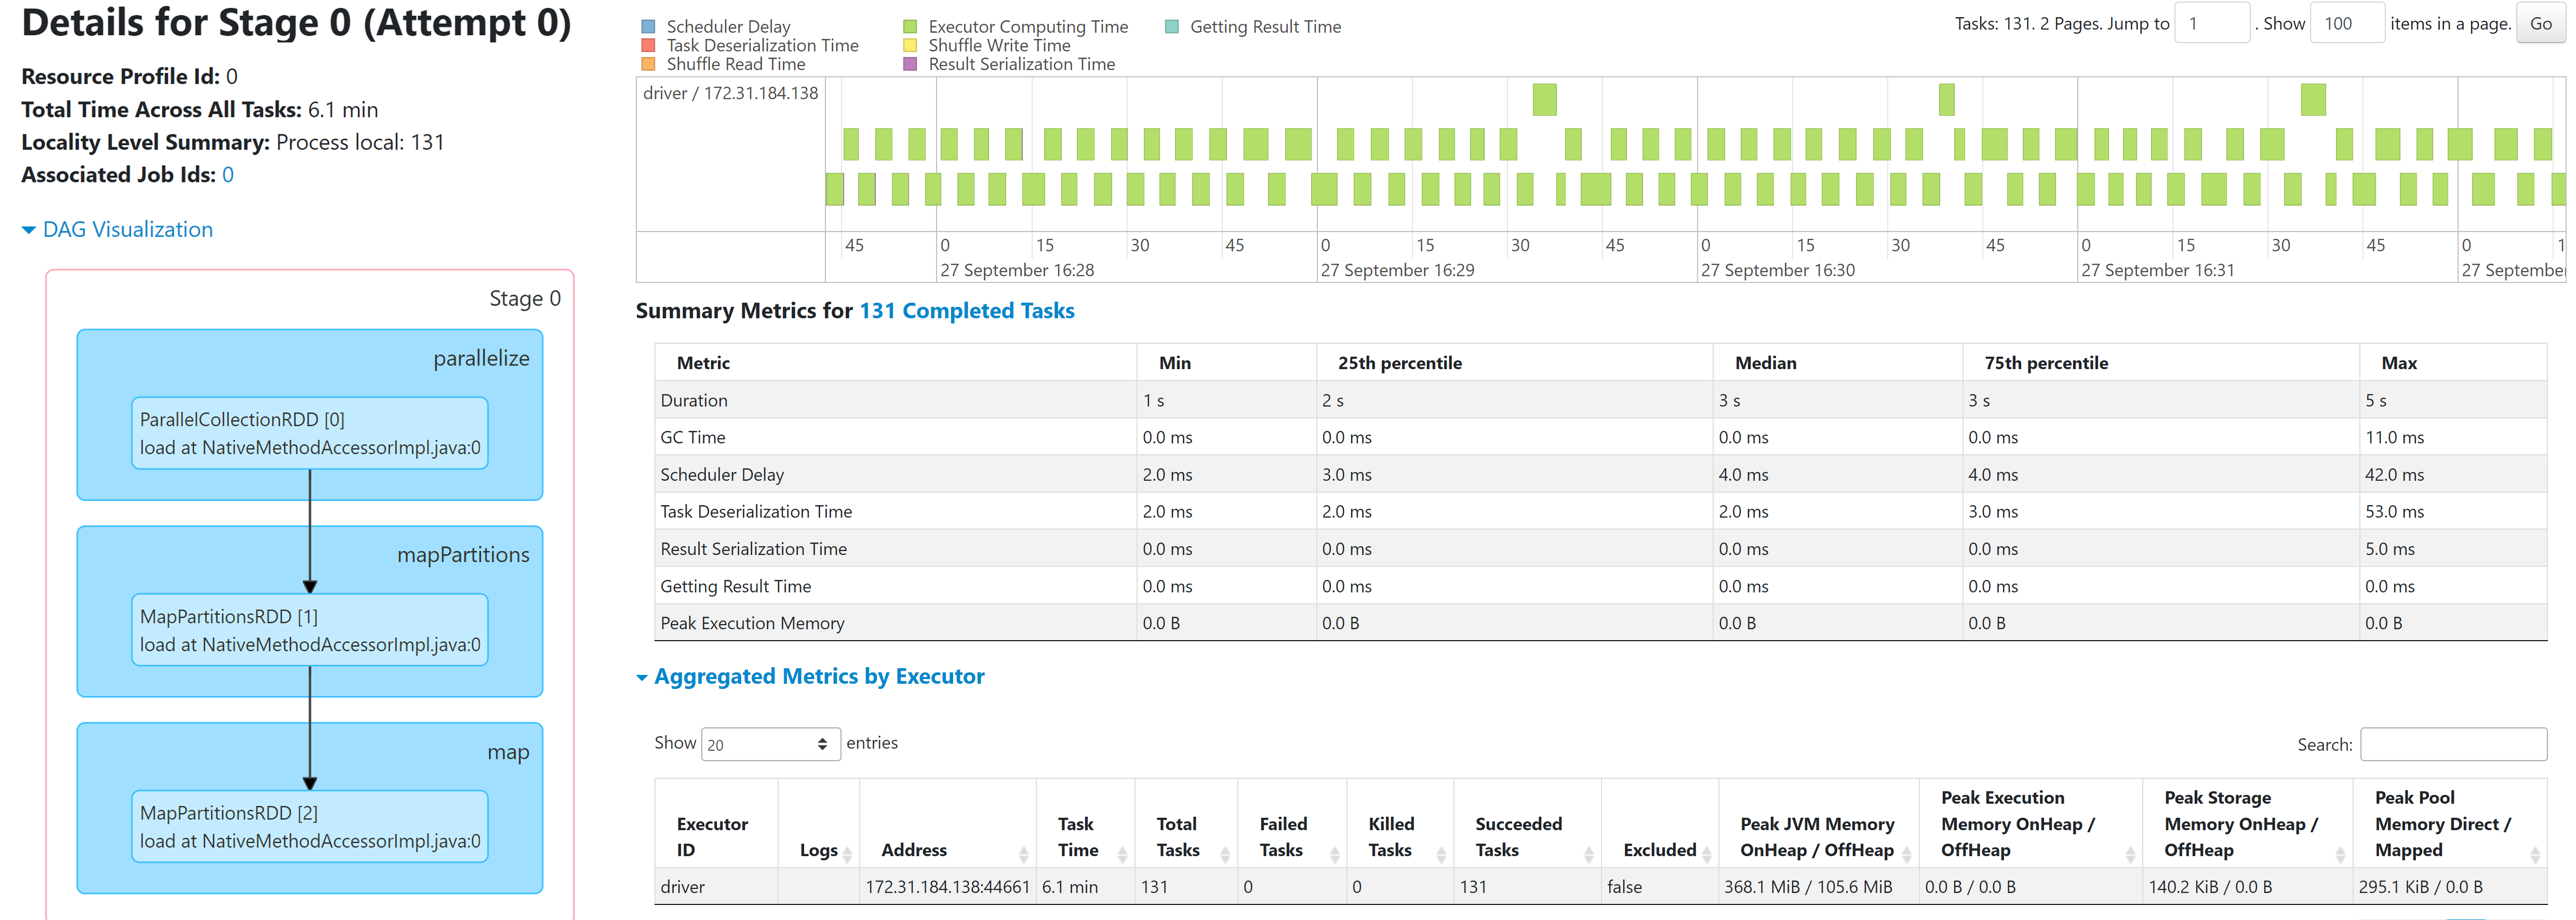

**Stage1:**
- Scan binaryFile 
- WholeStageCodegen (1)
- mapPartitionsInternal
- takeOrdered

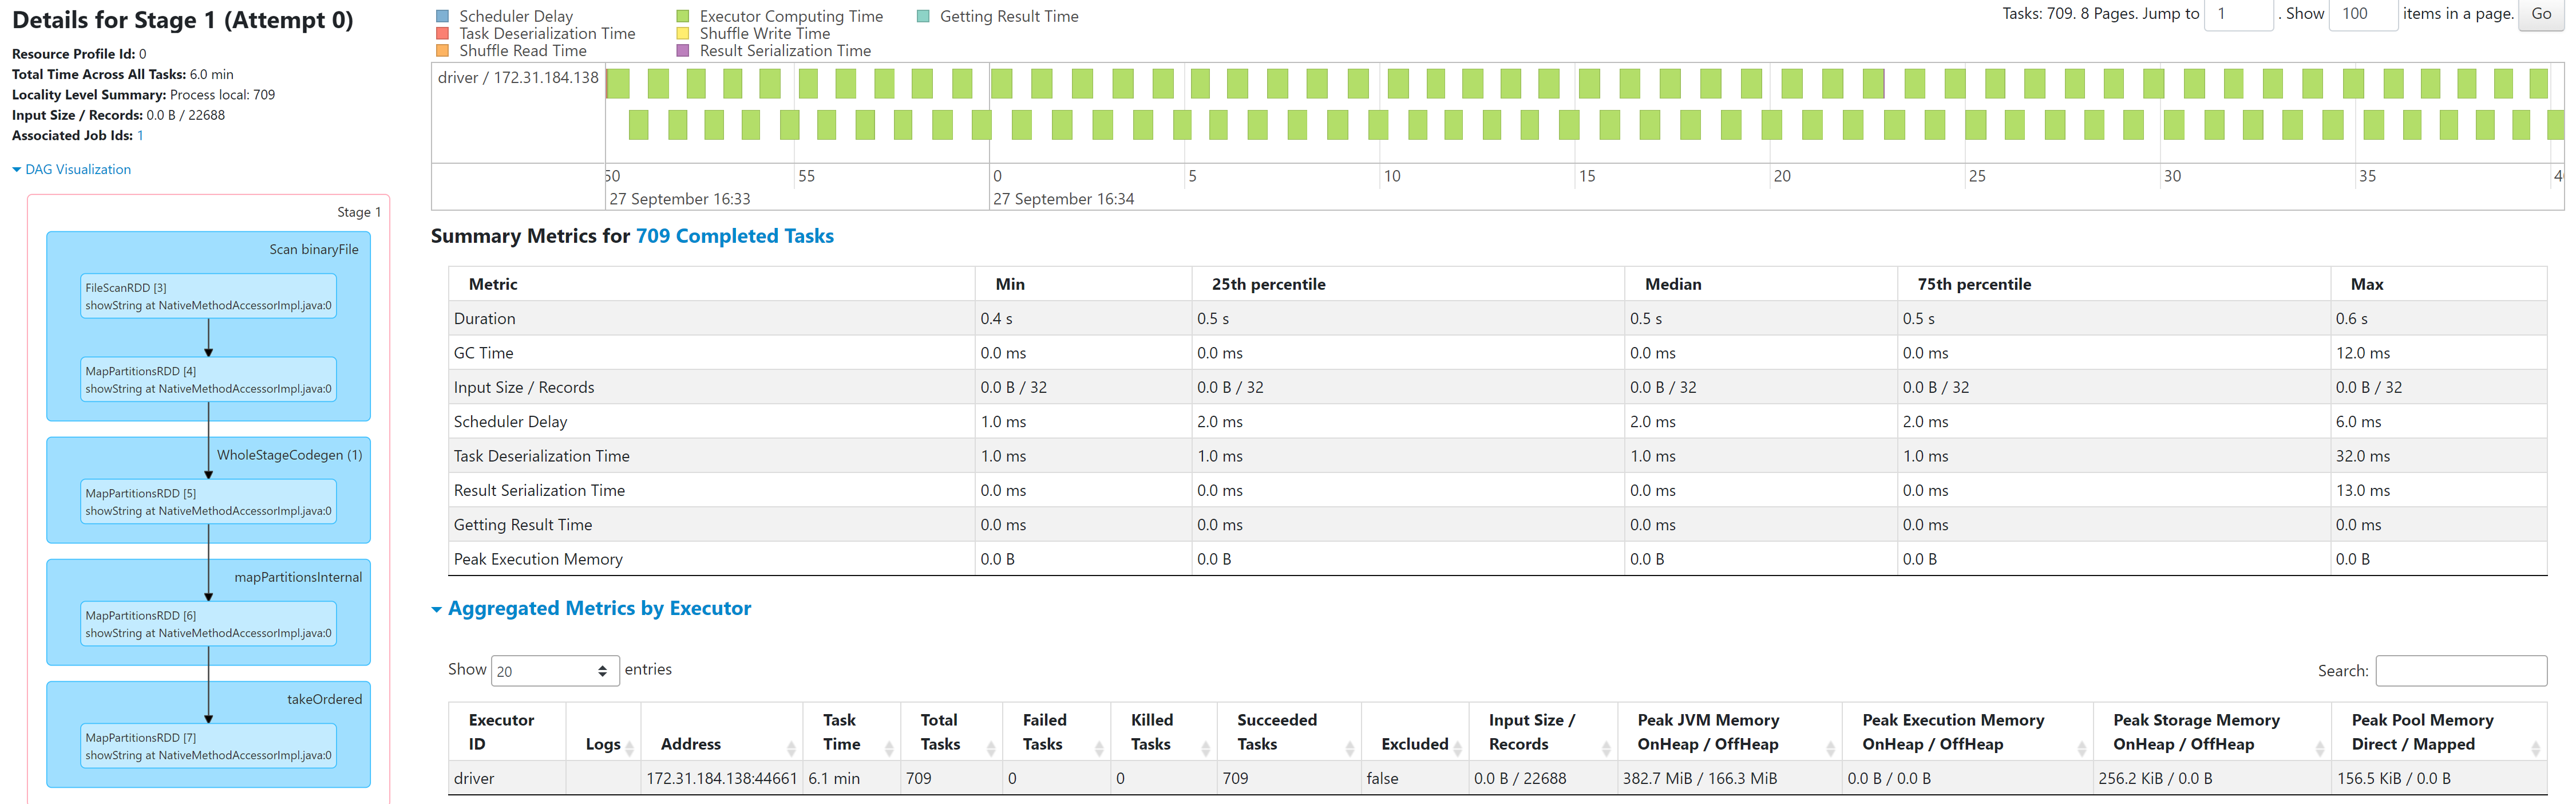

**Stage2:**
- Scan binaryFile 
- WholeStageCodegen (1)
- Exchange

**L'opération Exchange a déclenché un Shuffle (= cache des données)**
- Cela a permis un skip pour le Stage 3

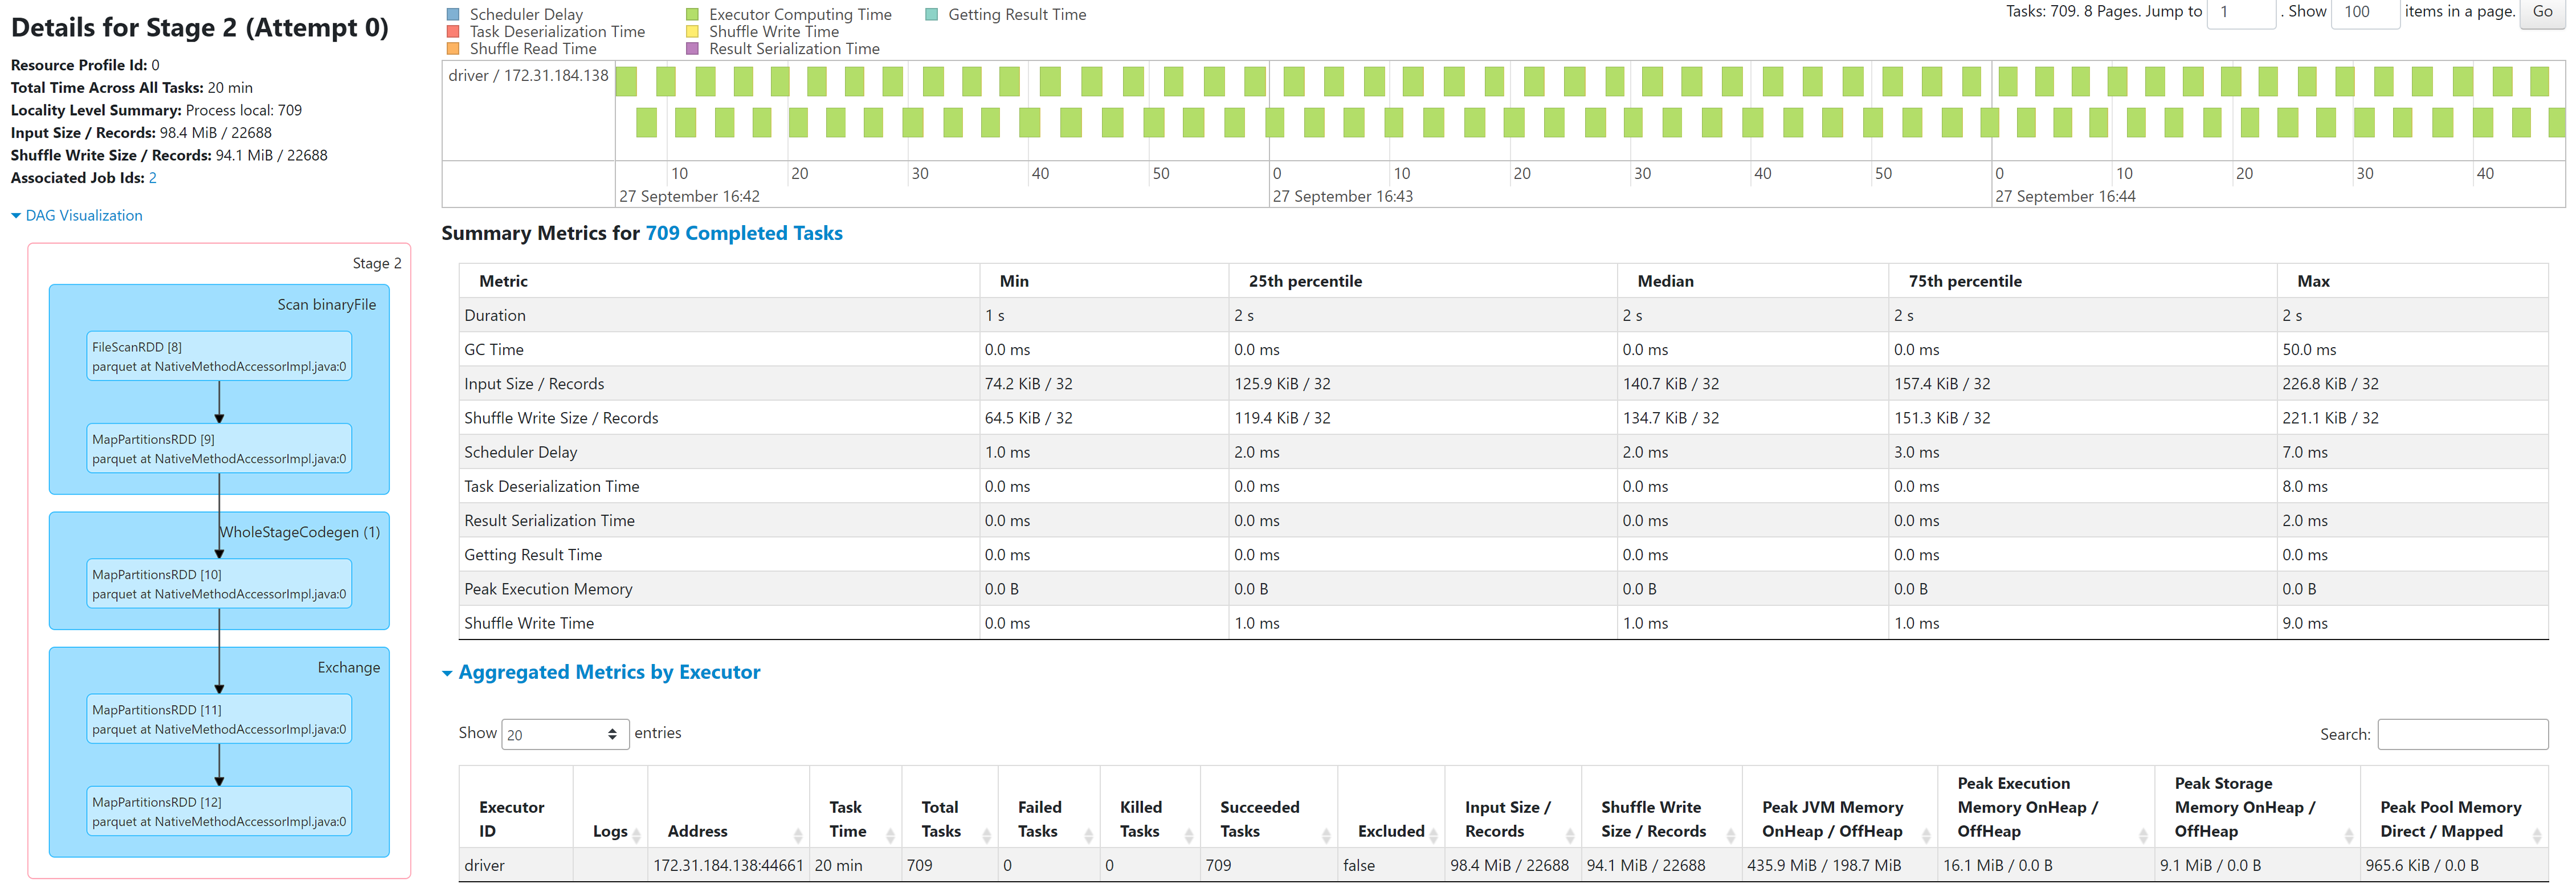

**Stage3:**
- Scan binaryFile 
- WholeStageCodegen (1)
- Exchange

**A été skip**

**Stage4:**
- Exchange
- ArrowEvalPython
- WholeStageCodegen (2)
- WriteFiles


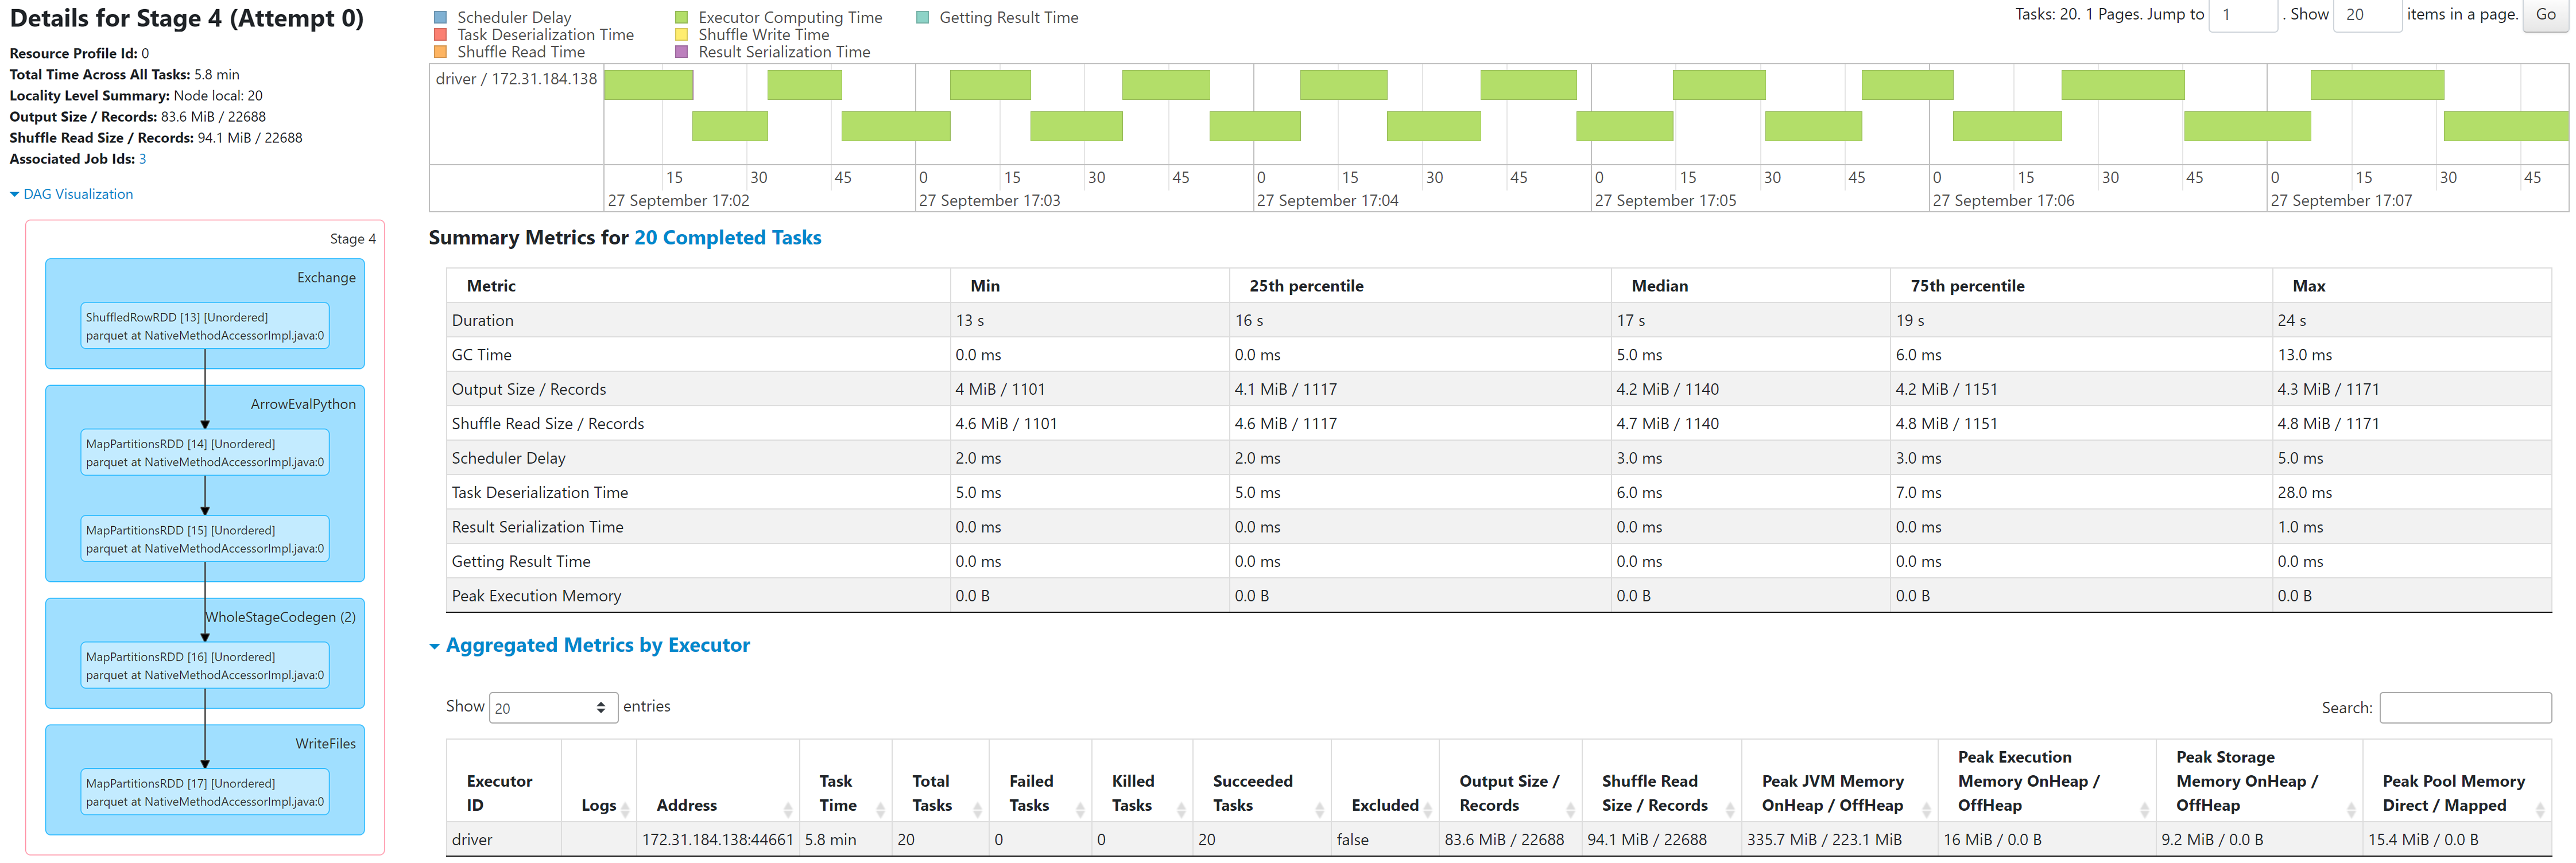

## Import des parquets et execution de la PCA

**On va charger les parquets dans un dataframe classique**

In [37]:
df = pd.read_parquet(PATH_Result, engine='pyarrow')

In [38]:
df

path               label  \
0      file:/mnt/c/Users/Home/Desktop/OpenClassrooms/...          Watermelon   
1      file:/mnt/c/Users/Home/Desktop/OpenClassrooms/...          Watermelon   
2      file:/mnt/c/Users/Home/Desktop/OpenClassrooms/...          Watermelon   
3      file:/mnt/c/Users/Home/Desktop/OpenClassrooms/...      Pineapple Mini   
4      file:/mnt/c/Users/Home/Desktop/OpenClassrooms/...      Pineapple Mini   
...                                                  ...                 ...   
22683  file:/mnt/c/Users/Home/Desktop/OpenClassrooms/...              Banana   
22684  file:/mnt/c/Users/Home/Desktop/OpenClassrooms/...  Banana Lady Finger   
22685  file:/mnt/c/Users/Home/Desktop/OpenClassrooms/...              Banana   
22686  file:/mnt/c/Users/Home/Desktop/OpenClassrooms/...  Banana Lady Finger   
22687  file:/mnt/c/Users/Home/Desktop/OpenClassrooms/...  Banana Lady Finger   

                                                features  
0      [0.16239043, 0.29253194, 0.0, 0.0057012695, 0....  
1      [0.028400578, 0.115830734, 0.0, 0.05681446, 0....  
2      [0.0, 0.2911048, 0.0, 0.0, 2.5285957, 0.366646...  
3      [0.0, 4.6874394, 0.0, 0.0, 0.0, 0.0, 0.1531428...  
4      [0.0035834312, 4.7988124, 0.0, 0.0, 0.0, 0.0, ...  
...                                                  ...  
22683  [0.8267609, 0.1315031, 0.0, 0.027190384, 0.464...  
22684  [0.061656263, 0.0, 0.13815665, 0.0, 1.77297, 0...  
22685  [0.80634004, 0.060510546, 0.0, 0.015315143, 0....  
22686  [0.062931955, 0.0, 0.37920862, 0.0, 1.6213832,...  
22687  [0.06825689, 0.0, 0.34533098, 0.0, 1.3032032, ...  

[22688 rows x 3 columns]

In [39]:
df.loc[0,'features'].shape

(1280,)

On a bien 1280 features pour chaque image

**Mon PC n'a pas assez de mémoire pour effectuer la PCA sur ces 20000 images, je vais utiliser un sample**

In [40]:
df = df.sample(frac=0.1, random_state=42)

In [41]:
df

path             label  \
15255  file:/mnt/c/Users/Home/Desktop/OpenClassrooms/...  Grapefruit White   
6119   file:/mnt/c/Users/Home/Desktop/OpenClassrooms/...              Corn   
3519   file:/mnt/c/Users/Home/Desktop/OpenClassrooms/...     Pepper Yellow   
10281  file:/mnt/c/Users/Home/Desktop/OpenClassrooms/...       Onion White   
13469  file:/mnt/c/Users/Home/Desktop/OpenClassrooms/...          Physalis   
...                                                  ...               ...   
12245  file:/mnt/c/Users/Home/Desktop/OpenClassrooms/...              Corn   
10092  file:/mnt/c/Users/Home/Desktop/OpenClassrooms/...        Pear Abate   
10727  file:/mnt/c/Users/Home/Desktop/OpenClassrooms/...  Strawberry Wedge   
290    file:/mnt/c/Users/Home/Desktop/OpenClassrooms/...             Guava   
8977   file:/mnt/c/Users/Home/Desktop/OpenClassrooms/...    Cherry Wax Red   

                                                features  
15255  [0.0, 0.0, 0.0022102862, 0.0, 0.0, 0.6010913, ...  
6119   [0.0, 0.06926703, 0.7947469, 0.0, 0.58684057, ...  
3519   [0.44384462, 0.009148714, 0.0, 0.0, 1.1143062,...  
10281  [0.011125234, 0.33460885, 0.0, 0.0, 0.0, 0.085...  
13469  [0.0, 0.8008824, 0.0, 0.0, 0.0, 0.05023966, 0....  
...                                                  ...  
12245  [0.90964586, 0.0, 0.0, 0.0, 0.0024151802, 0.02...  
10092  [0.2874405, 0.33531496, 0.055783942, 0.0820073...  
10727  [0.015877208, 1.4449558, 0.0, 0.48800623, 0.03...  
290    [0.38222674, 0.0, 0.017773258, 0.0, 0.0, 0.0, ...  
8977   [0.0, 0.51455694, 0.0, 0.0, 0.0, 2.7247689, 0....  

[2269 rows x 3 columns]

**On va déterminer le nb de composantes principales nécéssaires pour expliquer 95% de la variance**

In [13]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import PCA
from pyspark.sql.functions import udf

spark.sparkContext.setLogLevel("ERROR")

# Conversion du DataFrame Pandas en DataFrame PySpark
df['features'] = df['features'].apply(lambda x: Vectors.dense(x))
df_spark = spark.createDataFrame(df)

# Création d'un VectorAssembler qui combine une liste de colonnes en une seule colonne de vecteur.
vecAssembler = VectorAssembler(inputCols=["features"], outputCol="features_vec")

# Utilisation du VectorAssembler pour transformer notre DataFrame.
df_spark = vecAssembler.transform(df_spark)

variances = []
total_features = len(df_spark.select("features").first()[0])
step_size = int(total_features * 0.01) # 1% du nombre total de caractéristiques
# Initialisation de la liste des résultats
resultats = []

for k in range(1, total_features + 1, step_size):
    # Création d'une instance de PCA qui prend en entrée la colonne "features_vec" et renvoie la colonne "pcaFeatures".
    pca = PCA(k=k, inputCol="features_vec", outputCol="pcaFeatures")
    
    # Entraînement du modèle PCA.
    model = pca.fit(df_spark)
    
    # Ajout de la variance expliquée au tableau des variances.
    explained_variance = sum(model.explainedVariance)
    variances.append(explained_variance)

    # Ajout du nombre de caractéristiques et de la variance expliquée à la liste des résultats
    resultats.append((k, explained_variance))

    # Si la variance expliquée est égale à 1, arrêtez la boucle.
    if explained_variance >= 0.8:
        break

resultats.append(((total_features, 1.0)))

In [14]:
resultats

[(1, 0.10020649804403549),
 (13, 0.49526521693418163),
 (25, 0.619296136383471),
 (37, 0.6890735642450232),
 (49, 0.73591262879489),
 (61, 0.7705263427600677),
 (73, 0.7972937390534658),
 (85, 0.8188022848491081),
 (1280, 1.0)]

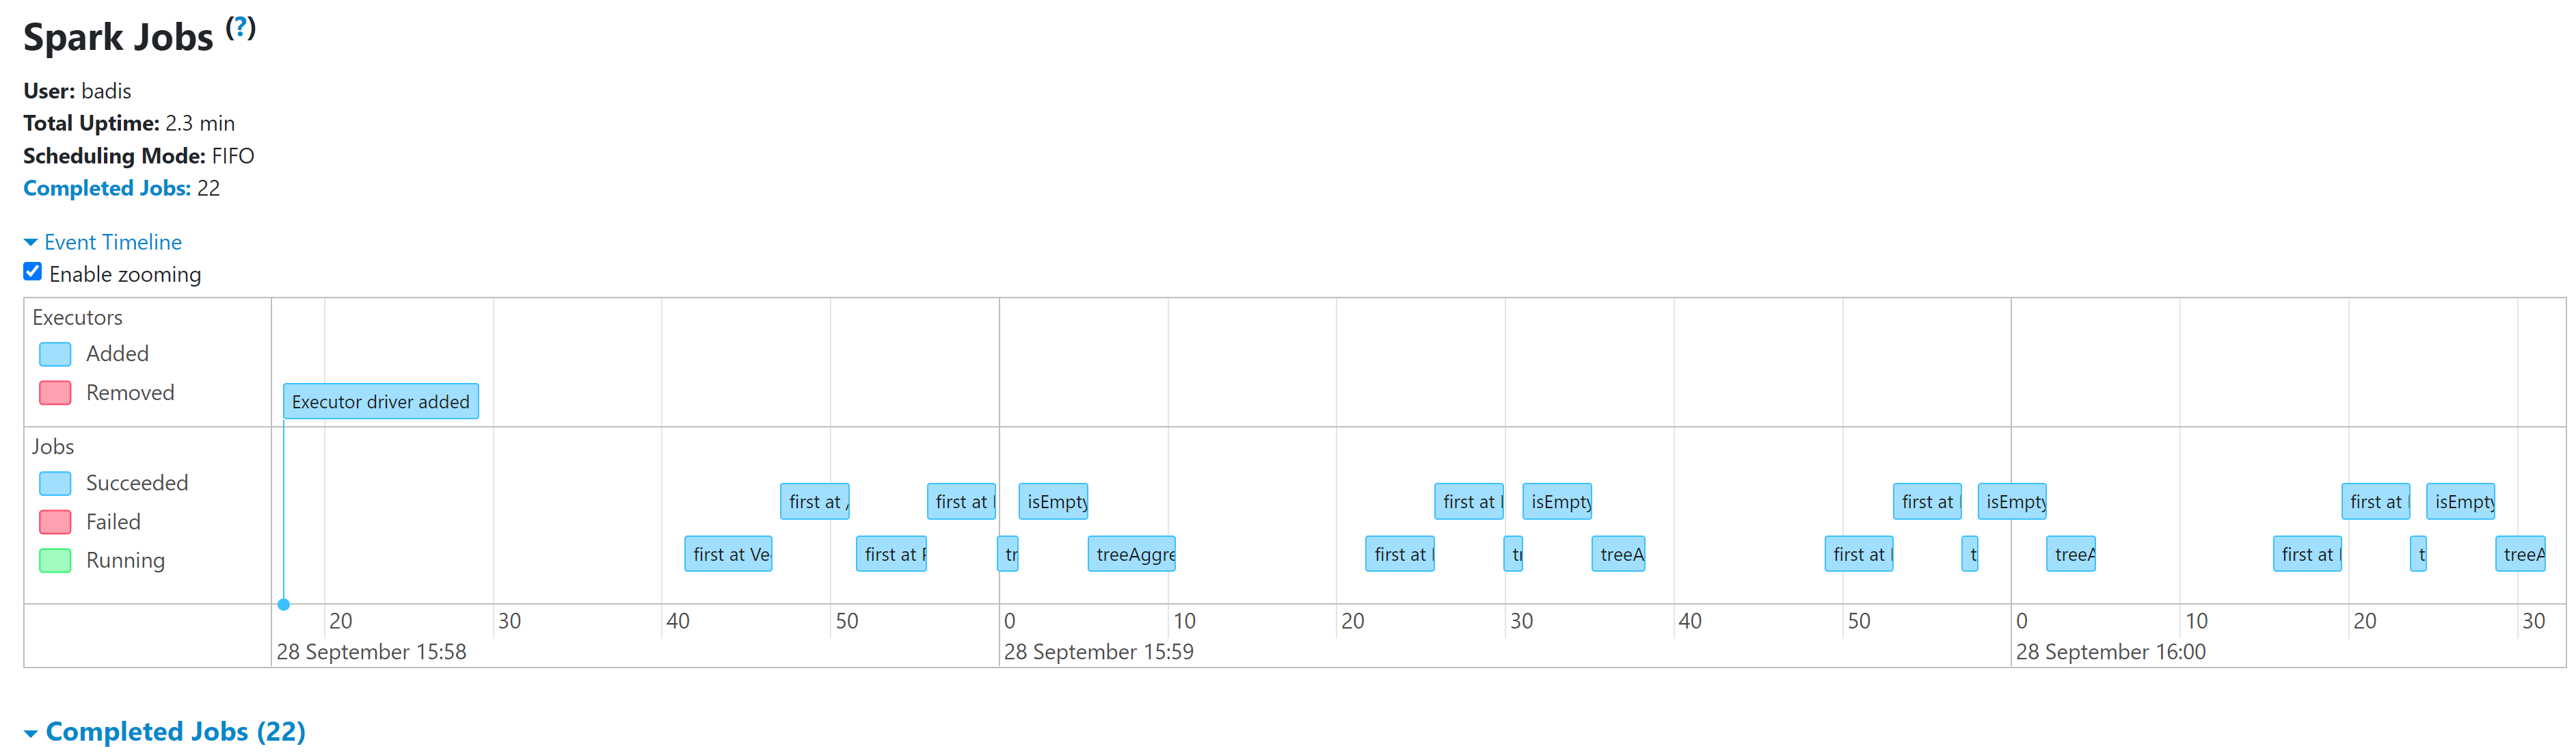

**7 stages distinctes:**
- 2 stages présent au tout début du calcul
    - first at VectorAssembler.scala
    - first at /tmp/ipykernel_7747/3629274763.py
- 5 stages réccursives (boucle)
    - first at PCA.scala
    - first at RowMatrix.scala
    - treeAggregate at Statistics.scala
    - isEmpty at RowMatrix.scala
    - treeAggregate at RowMatrix.scala

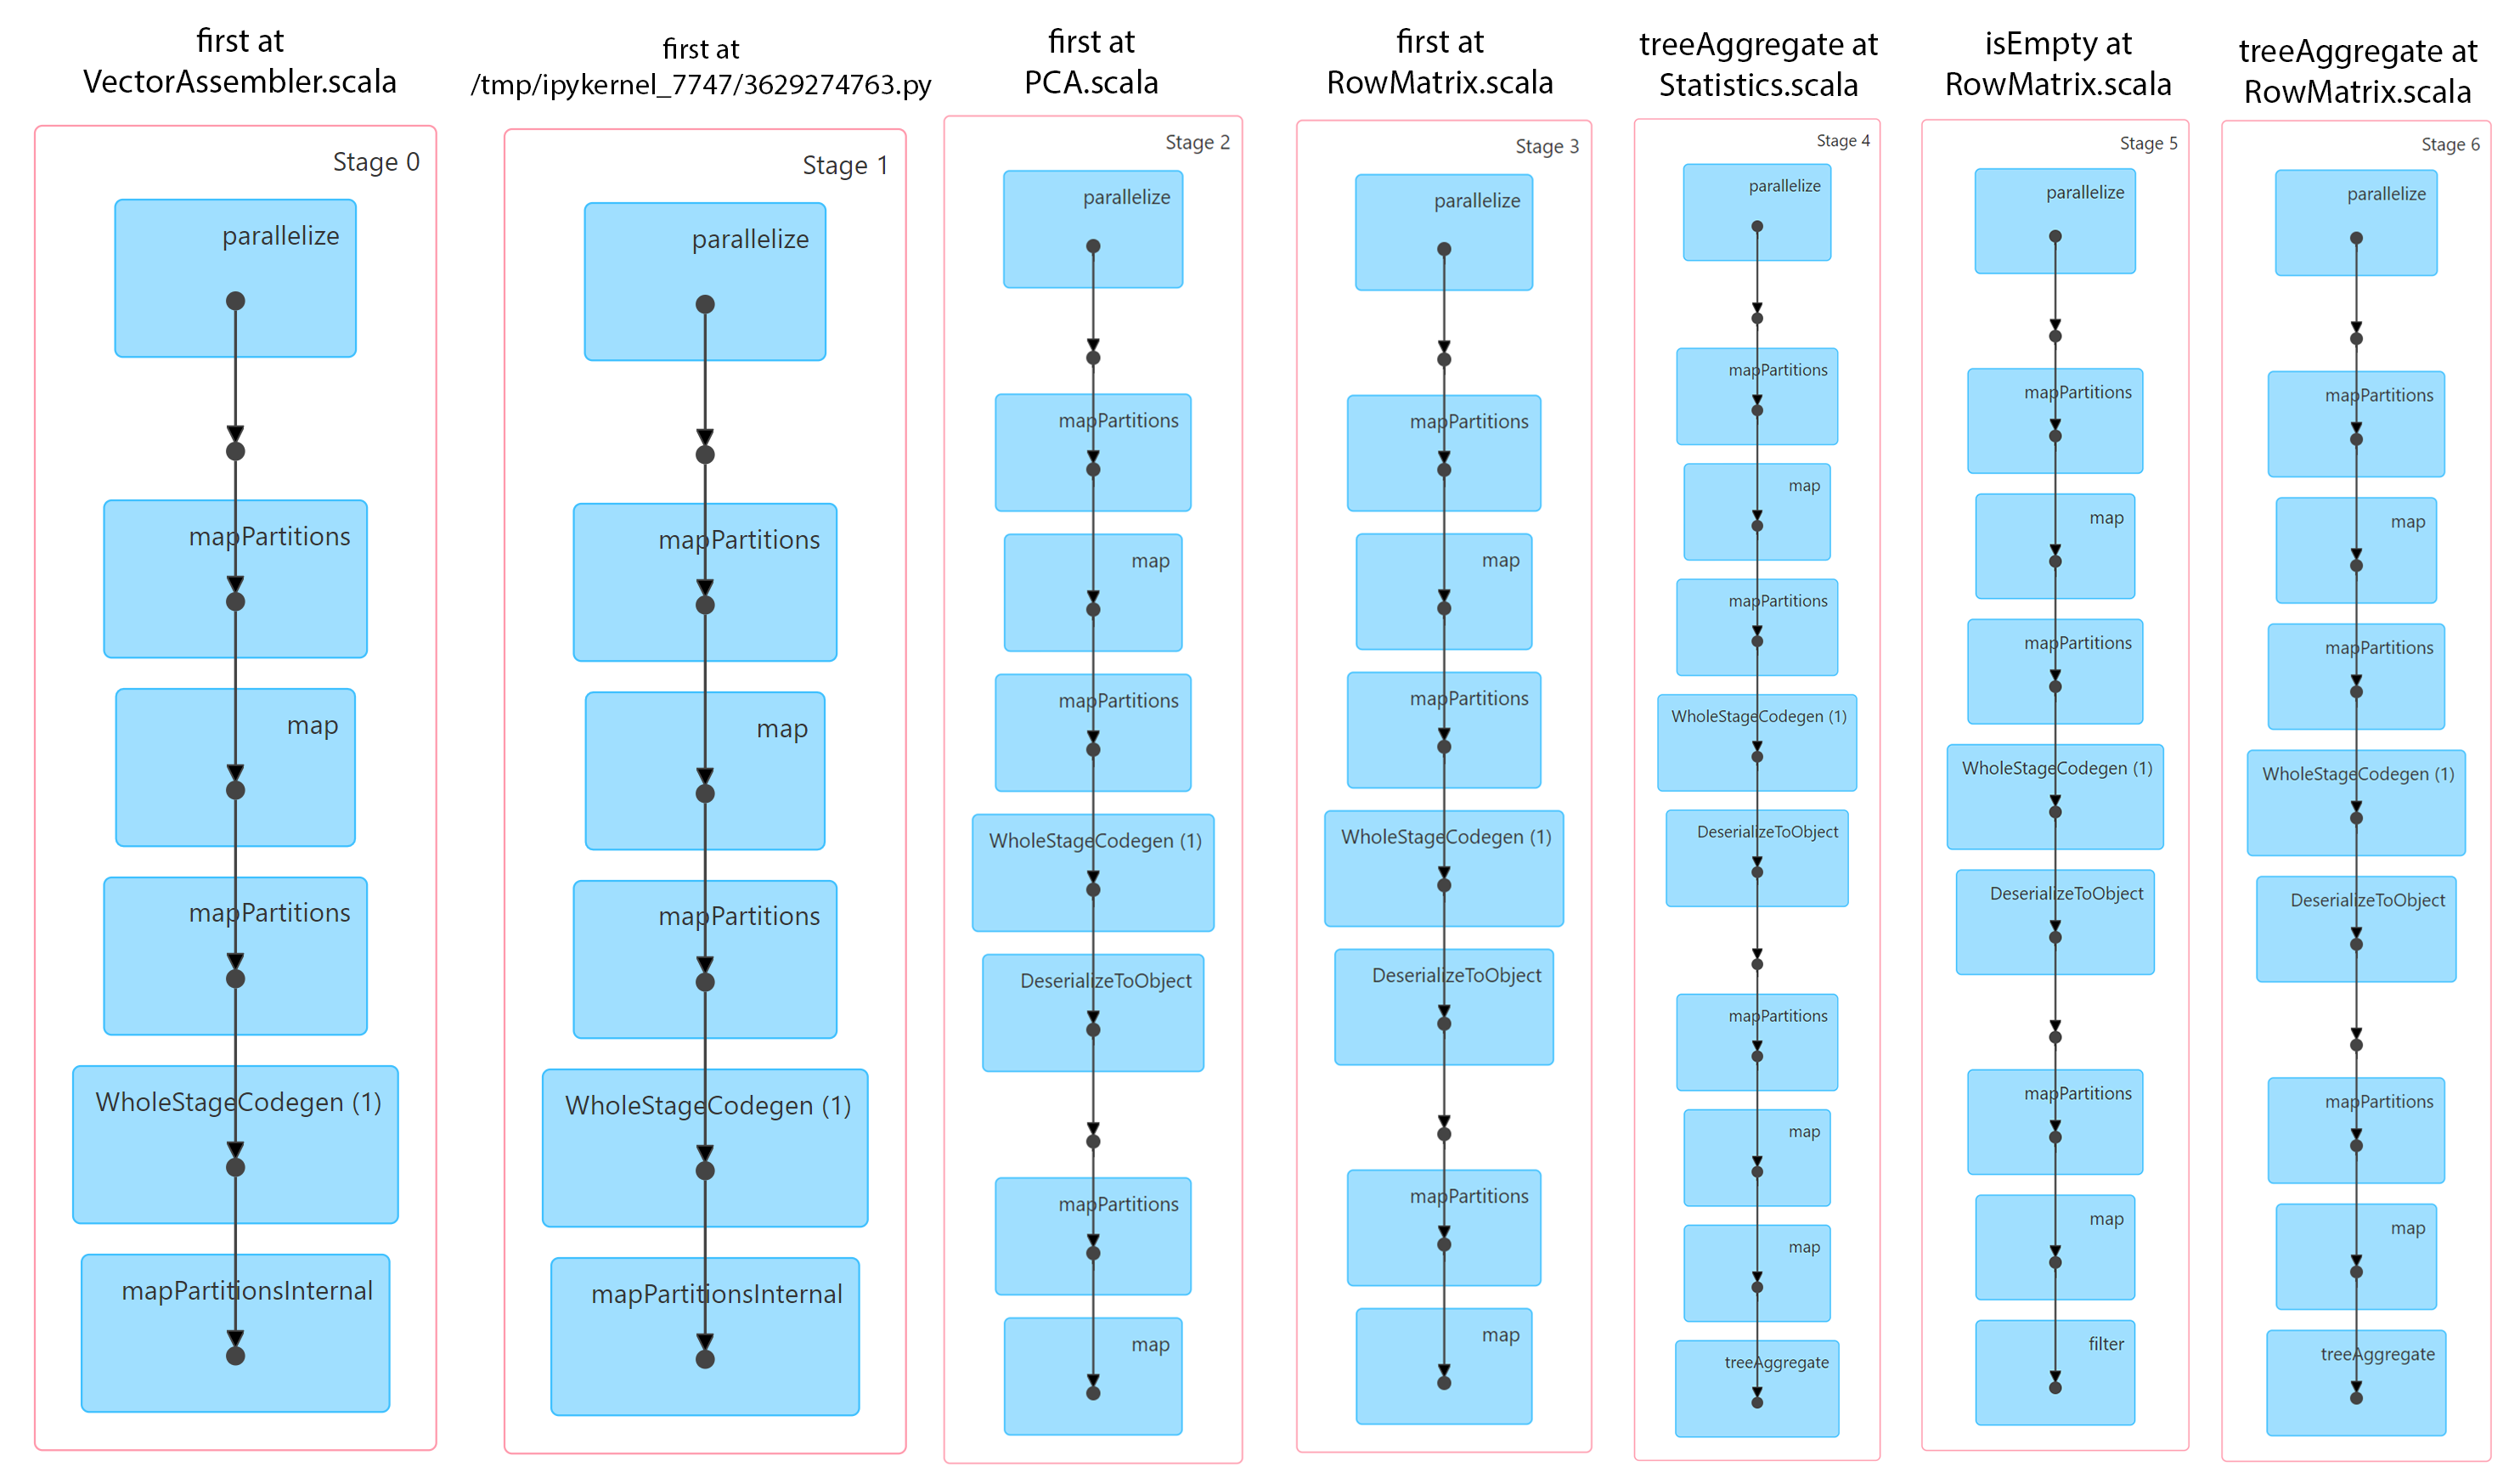

**On cré un graphe qui va nous permettre de déterminer le nb de composantes principales optimales**

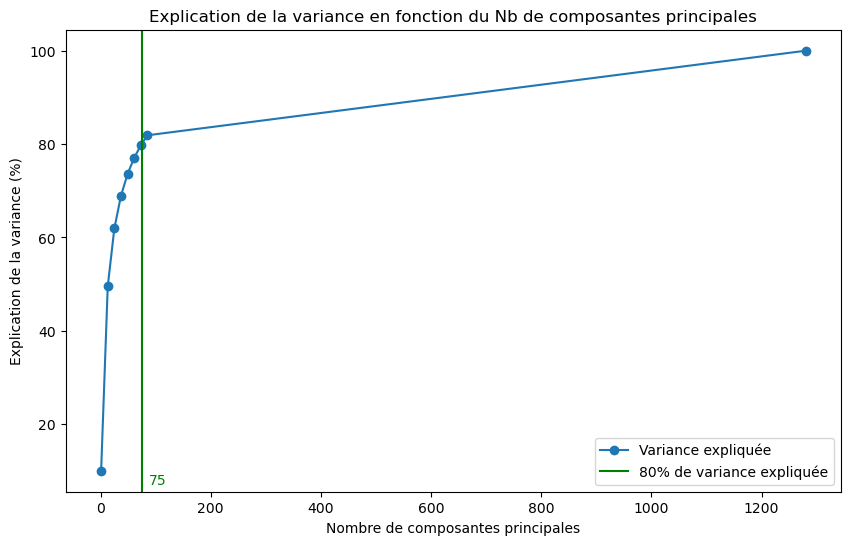

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import math

# Séparation des données en deux listes pour les axes x et y
x_data = [i[0] for i in resultats]
y_data = [i[1]*100 for i in resultats]

# Création du graphe
plt.figure(figsize=(10,6))
plt.plot(x_data, y_data, marker='o', label='Variance expliquée')

# Ajout des titres et labels
plt.title('Explication de la variance en fonction du Nb de composantes principales')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Explication de la variance (%)')

# Trouver la valeur x pour laquelle y atteint 80%
x_80 = np.interp(80, y_data, np.round(x_data))

# Tracer une ligne verticale à cette position x
plt.axvline(x=x_80, color='g', label='80% de variance expliquée')

# Ajouter la valeur de x en dessous du trait vertical
plt.text(x_80+30, 7, f'{math.ceil(x_80)}', color='g', ha='center')

# Afficher la légende
plt.legend()

# Affichage du graphe
plt.show()


In [17]:
Nb_composants_80 = math.ceil(x_80)
Nb_composants_80

75

**On va effectuer une PCA sur un nombre k de tel sorte à ce qu'on ait 80% de la variance expliquée:**

In [43]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

spark.sparkContext.setLogLevel("ERROR")

# Conversion du DataFrame Pandas en DataFrame PySpark
df['features'] = df['features'].apply(lambda x: Vectors.dense(x))
df_spark = spark.createDataFrame(df)

# Création d'un VectorAssembler qui combine une liste de colonnes en une seule colonne de vecteur.
vecAssembler = VectorAssembler(inputCols=["features"], outputCol="features_vec")

# Utilisation du VectorAssembler pour transformer notre DataFrame.
df_spark = vecAssembler.transform(df_spark)

# Création d'un objet PCA 
pca = PCA(k=Nb_composants_80, inputCol="features_vec", outputCol="pcaFeatures")

# Entraînement du modèle PCA sur les données
model = pca.fit(df_spark)

# Transformation des données avec le modèle PCA
result = model.transform(df_spark)

# Suppression de la colonne 'features_vec'
result = result.drop('features_vec')

# Affichage des résultats
result.show()

+--------------------+------------------+--------------------+--------------------+
|                path|             label|            features|         pcaFeatures|
+--------------------+------------------+--------------------+--------------------+
|file:/mnt/c/Users...|  Grapefruit White|[0.0,0.0,0.002210...|[0.87412100265354...|
|file:/mnt/c/Users...|              Corn|[0.0,0.0692670270...|[-3.4391576304209...|
|file:/mnt/c/Users...|     Pepper Yellow|[0.44384461641311...|[7.37730942760596...|
|file:/mnt/c/Users...|       Onion White|[0.01112523395568...|[0.41351782217150...|
|file:/mnt/c/Users...|          Physalis|[0.0,0.8008823990...|[8.22620342616334...|
|file:/mnt/c/Users...|        Strawberry|[2.15083503723144...|[0.86041268982125...|
|file:/mnt/c/Users...|             Peach|[0.27597847580909...|[7.10651553397163...|
|file:/mnt/c/Users...|          Pear Red|[0.99783307313919...|[1.70103901460179...|
|file:/mnt/c/Users...|  Cherry Wax Black|[0.0,0.0,0.0,0.0,...|[15.9414470924

**On cré un nouveau PATH qui sera PATH_Results_PCA (pour enregistrer les features PCA)**

In [6]:
PATH = os.getcwd()
PATH_Data = os.path.join(PATH, 'data', 'Test1')
PATH_Result_PCA = os.path.join(PATH, 'data', 'Results_PCA')

print('PATH:        '+\
      PATH+'\nPATH_Data:   '+\
      PATH_Data+'\nPATH_Results_PCA: '+PATH_Result_PCA)

PATH:        /mnt/c/Users/Home/Desktop/OpenClassrooms/Projet8/Projet
PATH_Data:   /mnt/c/Users/Home/Desktop/OpenClassrooms/Projet8/Projet/data/Test1
PATH_Results_PCA: /mnt/c/Users/Home/Desktop/OpenClassrooms/Projet8/Projet/data/Results_PCA


**On enregistre ces résultats dans le format parquet**

In [45]:
from pyspark.sql.functions import udf
from pyspark.ml.linalg import VectorUDT, DenseVector
from pyspark.sql.types import ArrayType, FloatType

# UDF pour convertir Vector en list
vector_to_list = udf(lambda v: v.toArray().tolist(), ArrayType(FloatType()))

# Appliquer la conversion
result = result.withColumn("features", vector_to_list(result["features"]))
result = result.withColumn("pcaFeatures", vector_to_list(result["pcaFeatures"]))

# Écrire dans Parquet
result.write.mode('overwrite').parquet(PATH_Result_PCA)

In [7]:
df = pd.read_parquet(PATH_Result_PCA, engine='pyarrow')

In [8]:
df

path             label  \
0     file:/mnt/c/Users/Home/Desktop/OpenClassrooms/...  Grapefruit White   
1     file:/mnt/c/Users/Home/Desktop/OpenClassrooms/...              Corn   
2     file:/mnt/c/Users/Home/Desktop/OpenClassrooms/...     Pepper Yellow   
3     file:/mnt/c/Users/Home/Desktop/OpenClassrooms/...       Onion White   
4     file:/mnt/c/Users/Home/Desktop/OpenClassrooms/...          Physalis   
...                                                 ...               ...   
2264  file:/mnt/c/Users/Home/Desktop/OpenClassrooms/...              Corn   
2265  file:/mnt/c/Users/Home/Desktop/OpenClassrooms/...        Pear Abate   
2266  file:/mnt/c/Users/Home/Desktop/OpenClassrooms/...  Strawberry Wedge   
2267  file:/mnt/c/Users/Home/Desktop/OpenClassrooms/...             Guava   
2268  file:/mnt/c/Users/Home/Desktop/OpenClassrooms/...    Cherry Wax Red   

                                               features  \
0     [0.0, 0.0, 0.0022102862, 0.0, 0.0, 0.6010913, ...   
1     [0.0, 0.06926703, 0.7947469, 0.0, 0.58684057, ...   
2     [0.44384462, 0.009148714, 0.0, 0.0, 1.1143062,...   
3     [0.011125234, 0.33460885, 0.0, 0.0, 0.0, 0.085...   
4     [0.0, 0.8008824, 0.0, 0.0, 0.0, 0.05023966, 0....   
...                                                 ...   
2264  [0.90964586, 0.0, 0.0, 0.0, 0.0024151802, 0.02...   
2265  [0.2874405, 0.33531496, 0.055783942, 0.0820073...   
2266  [0.015877208, 1.4449558, 0.0, 0.48800623, 0.03...   
2267  [0.38222674, 0.0, 0.017773258, 0.0, 0.0, 0.0, ...   
2268  [0.0, 0.51455694, 0.0, 0.0, 0.0, 2.7247689, 0....   

                                            pcaFeatures  
0     [0.874121, -8.052725, -6.236199, 0.45361584, 2...  
1     [-3.4391577, 4.956928, -0.6189635, -2.4201674,...  
2     [7.3773093, 1.5729761, 3.3220696, -3.3303246, ...  
3     [0.41351783, 2.3262575, -5.8135004, -6.5749617...  
4     [8.226203, -5.759028, -0.87396586, -3.3095431,...  
...                                                 ...  
2264  [-1.6878189, -0.44720462, 2.8474603, -0.564684...  
2265  [-2.6073744, 7.0559483, -6.4622445, -5.5494895...  
2266  [-1.3242162, 7.3896785, -1.975336, -7.99437, 0...  
2267  [-1.0628915, -3.4787464, -8.044411, -3.9175181...  
2268  [19.86114, 4.5891805, -6.215733, -3.3389382, 1...  

[2269 rows x 4 columns]

# Configuration PySpark sur le Cloud (AWS)

## Choix du cloud

**Amazon Web Services (AWS) sera choisi:**
- On peut louer de la puissance de calcul **à la demande**
- Permet de s'adapter à la situation ou le volume de données venait à fortement augmenter
- Diminue fortement les coûts si on compare a une location a durée fixe (1 an par exemple)

## Choix du service

**1. Solution IAAS (Infrastructure AS A Service)**
- Les serveurs sont vierges
- On doit installer nous même tout les outils pour notre script (Spark, Java, Python, Jupyter...)
- **Inconvénient:** Chronophage

**2. Solution PAAS (Plateforme As A Service)**
- Spark,Tensorflow ainsi que JupyterHub sont déja installés
- Possibilité d'indiquer des packages complémentaires à installer
- Evolutive et Compatible
- Sécurisé -> Les patchs de sécurité sont automatiquement mis à jour
- **Avantage:** Rapide, facile de cloner ces clusters

**La solution PASS est par conséquent le mieux adapté pour ce projet**

## Choix du Stockage

**Amazon S3 (Amazon Simple Storage Service) sera utilisé**
- On peut garder données importantes dessus lorsqu'on résilie le serveur (pour des raisons de couts)
- L'espace disque disponible est illimité car indépendant des serveurs EC2
- Le PATH est simple -> format s3://... 

## Etape #1: Création utilisateur

**Dans IAM, nous allons tout d'abord créer un utilisateur**
- IAM -> Utilisateurs -> Créer un utilisateur

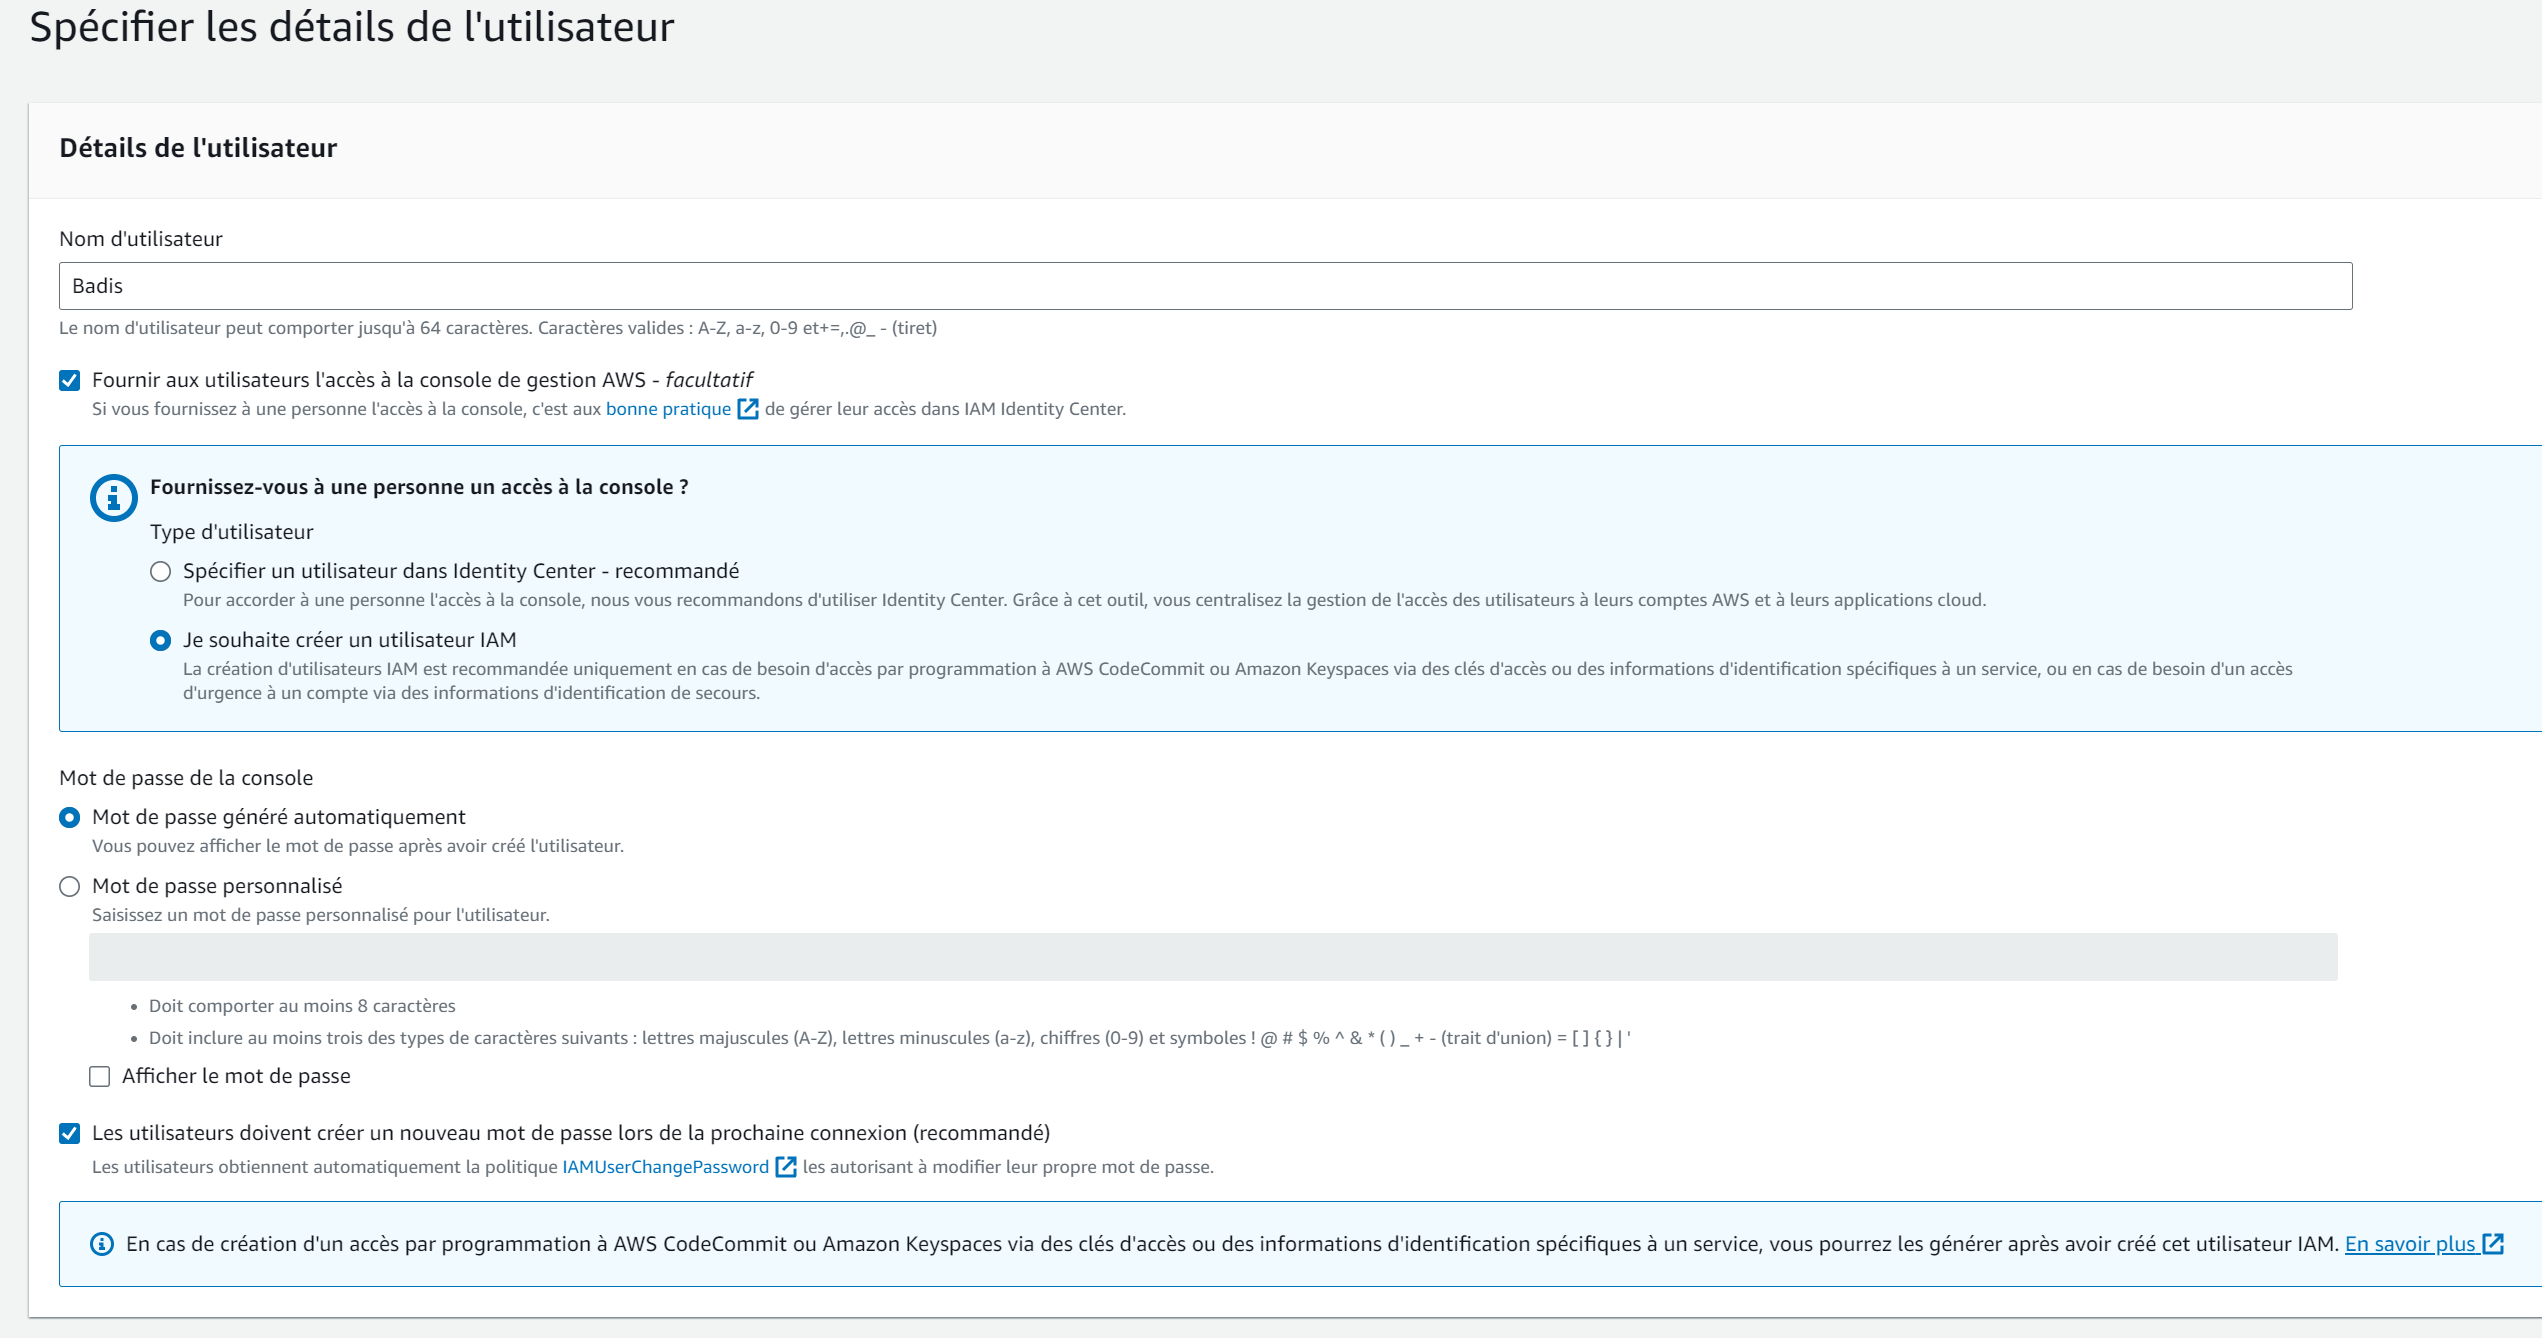

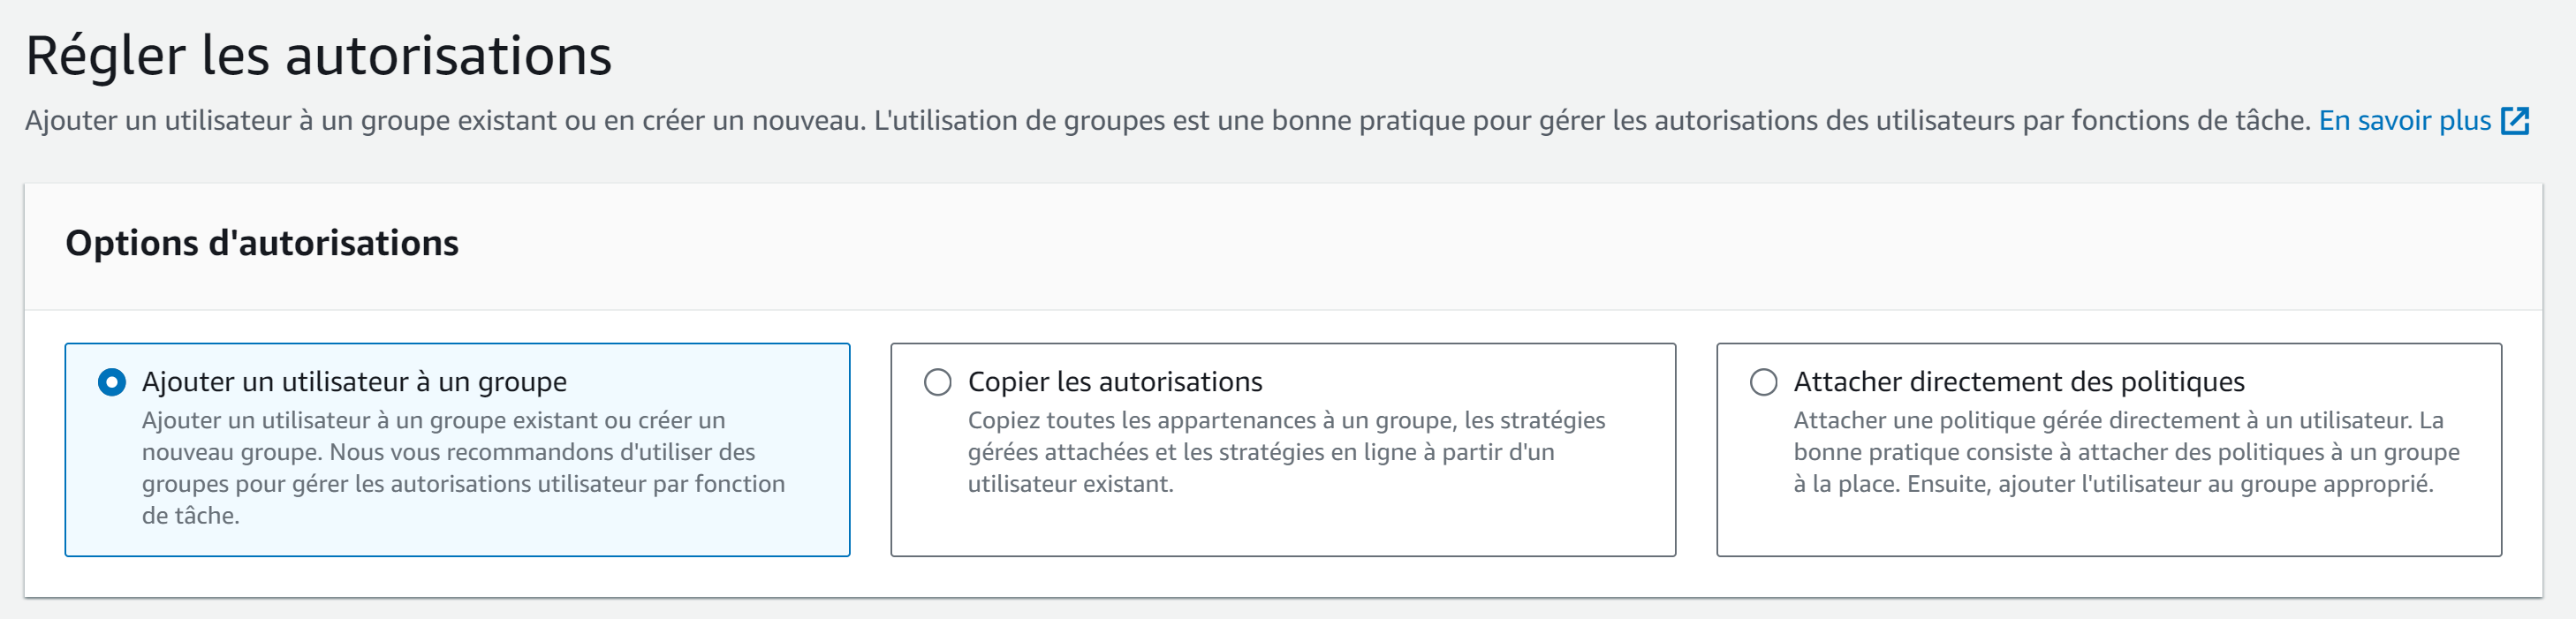

**On télécharge le csv pour récupérer:**
- Nom d'utilisateur
- Mot de passe
-URL de connexion à la console

## Etape #2: Ajout autorisations utilisateur

### Toutes les autorisations sur S3

IAM -> Utilisateurs -> Nom Utilisateur -> Ajouter des autorisations -> Créer une politique en ligne -> Cliquer sur "JSON"

**Le JSON doit ressembler à ca**

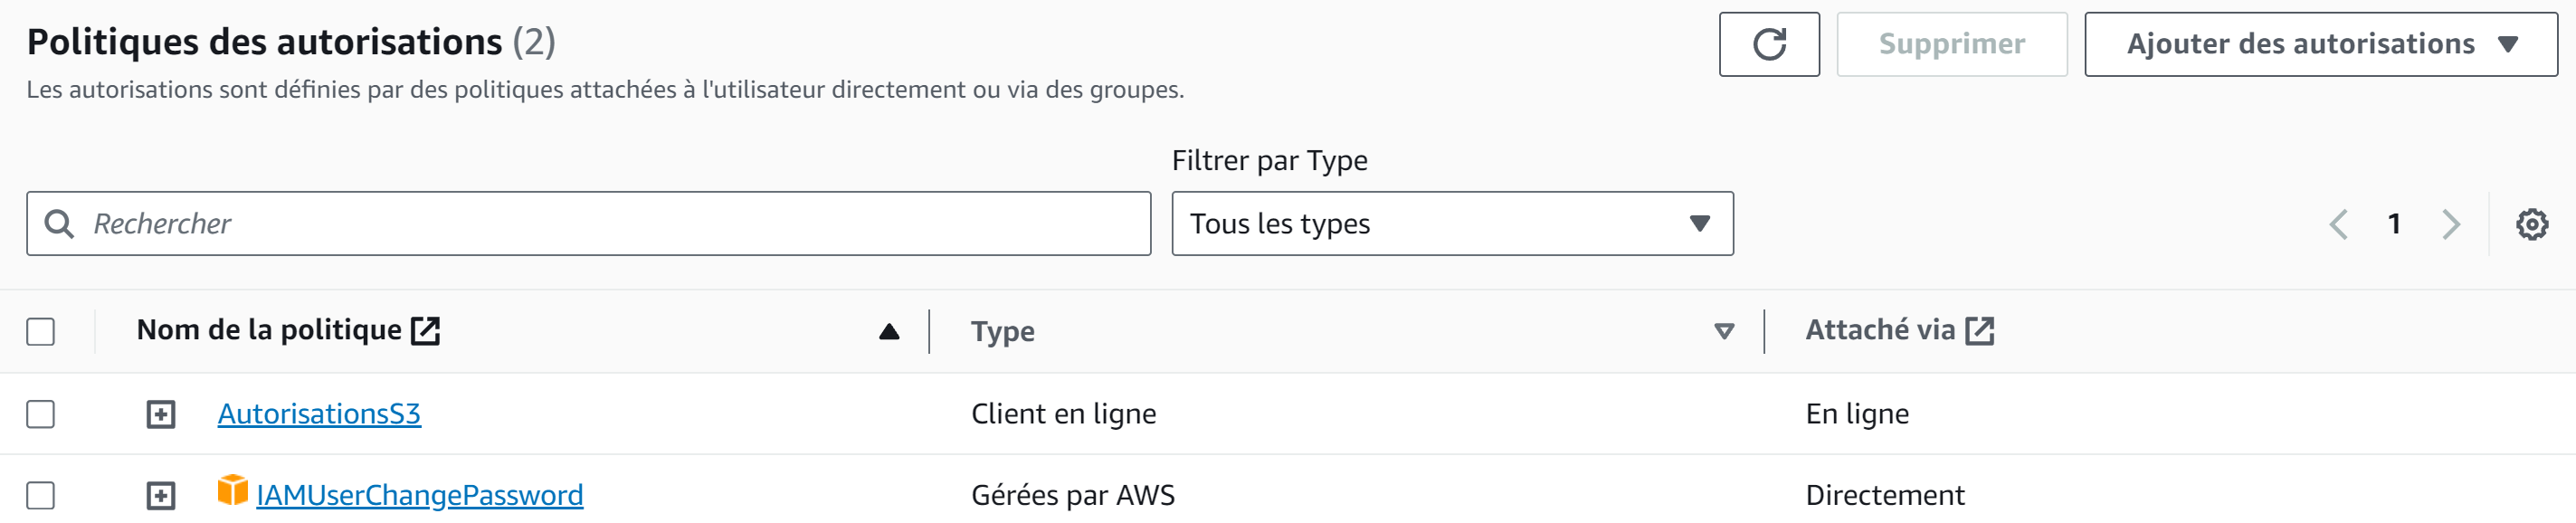

## Etape #3: Création paire de clés Utilisateur

- IAM -> Utilisateurs -> Créer une clé d'accès
- Choisir "Interface de ligne de commande (CLI)" -> Cliquer sur "Confirmation" et "Suivant"
- Télécharger le csv qui contient la paire de clés

## Etape #4: Installation package AWS CLI et configuration

**Permet d'intéragir avec l'API d'AWS**

In [22]:
pip install awscli

Note: you may need to restart the kernel to use updated packages.


**On vérifie que la commande aws est disponible**

In [29]:
!which aws

/home/badis/anaconda3/bin/aws


**On configure aws pour qu'il utilise la clé d'accès (à faire sur une commande bash)**   
On choisit **eu-west-3** -> Serveurs à **Paris**

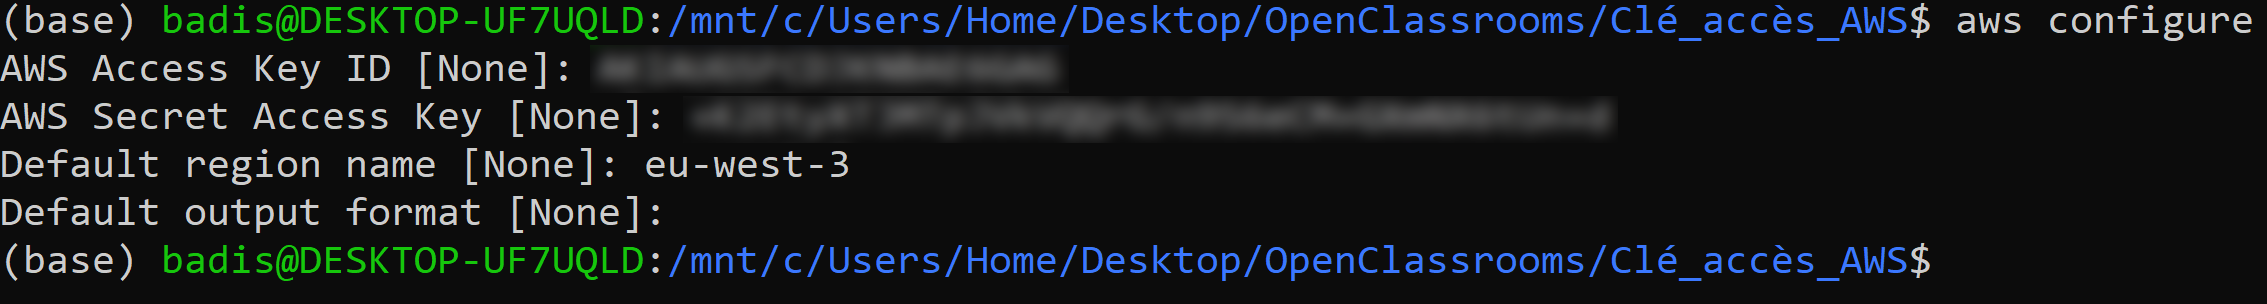

**On vérifie que tout s'est bien passé en vérifiant ce qu'on a dans s3 par exemple:**
- Si on a rien cela signifie que s3 ne contient rien mais qu'on n'a pas d'érreur

In [30]:
!aws s3 ls

## Etape #5: Création d'un bucket s3

In [32]:
!aws s3 mb s3://p8-data-badis

make_bucket: p8-data-badis


**On vérifie qu'on a bien notre bucket s3**

In [33]:
!aws s3 ls

2023-10-03 16:11:36 p8-data-badis


## Etape #6: Ajout du Dossier contenant les images dans le bucket

**Il faut se mettre dans le dossier contenant les images et ouvrir bash**  
*C:\Users\Home\Desktop\OpenClassrooms\Projet8\Projet\data\Test1*

"sync" permet de synchroniser les 2 répertoires

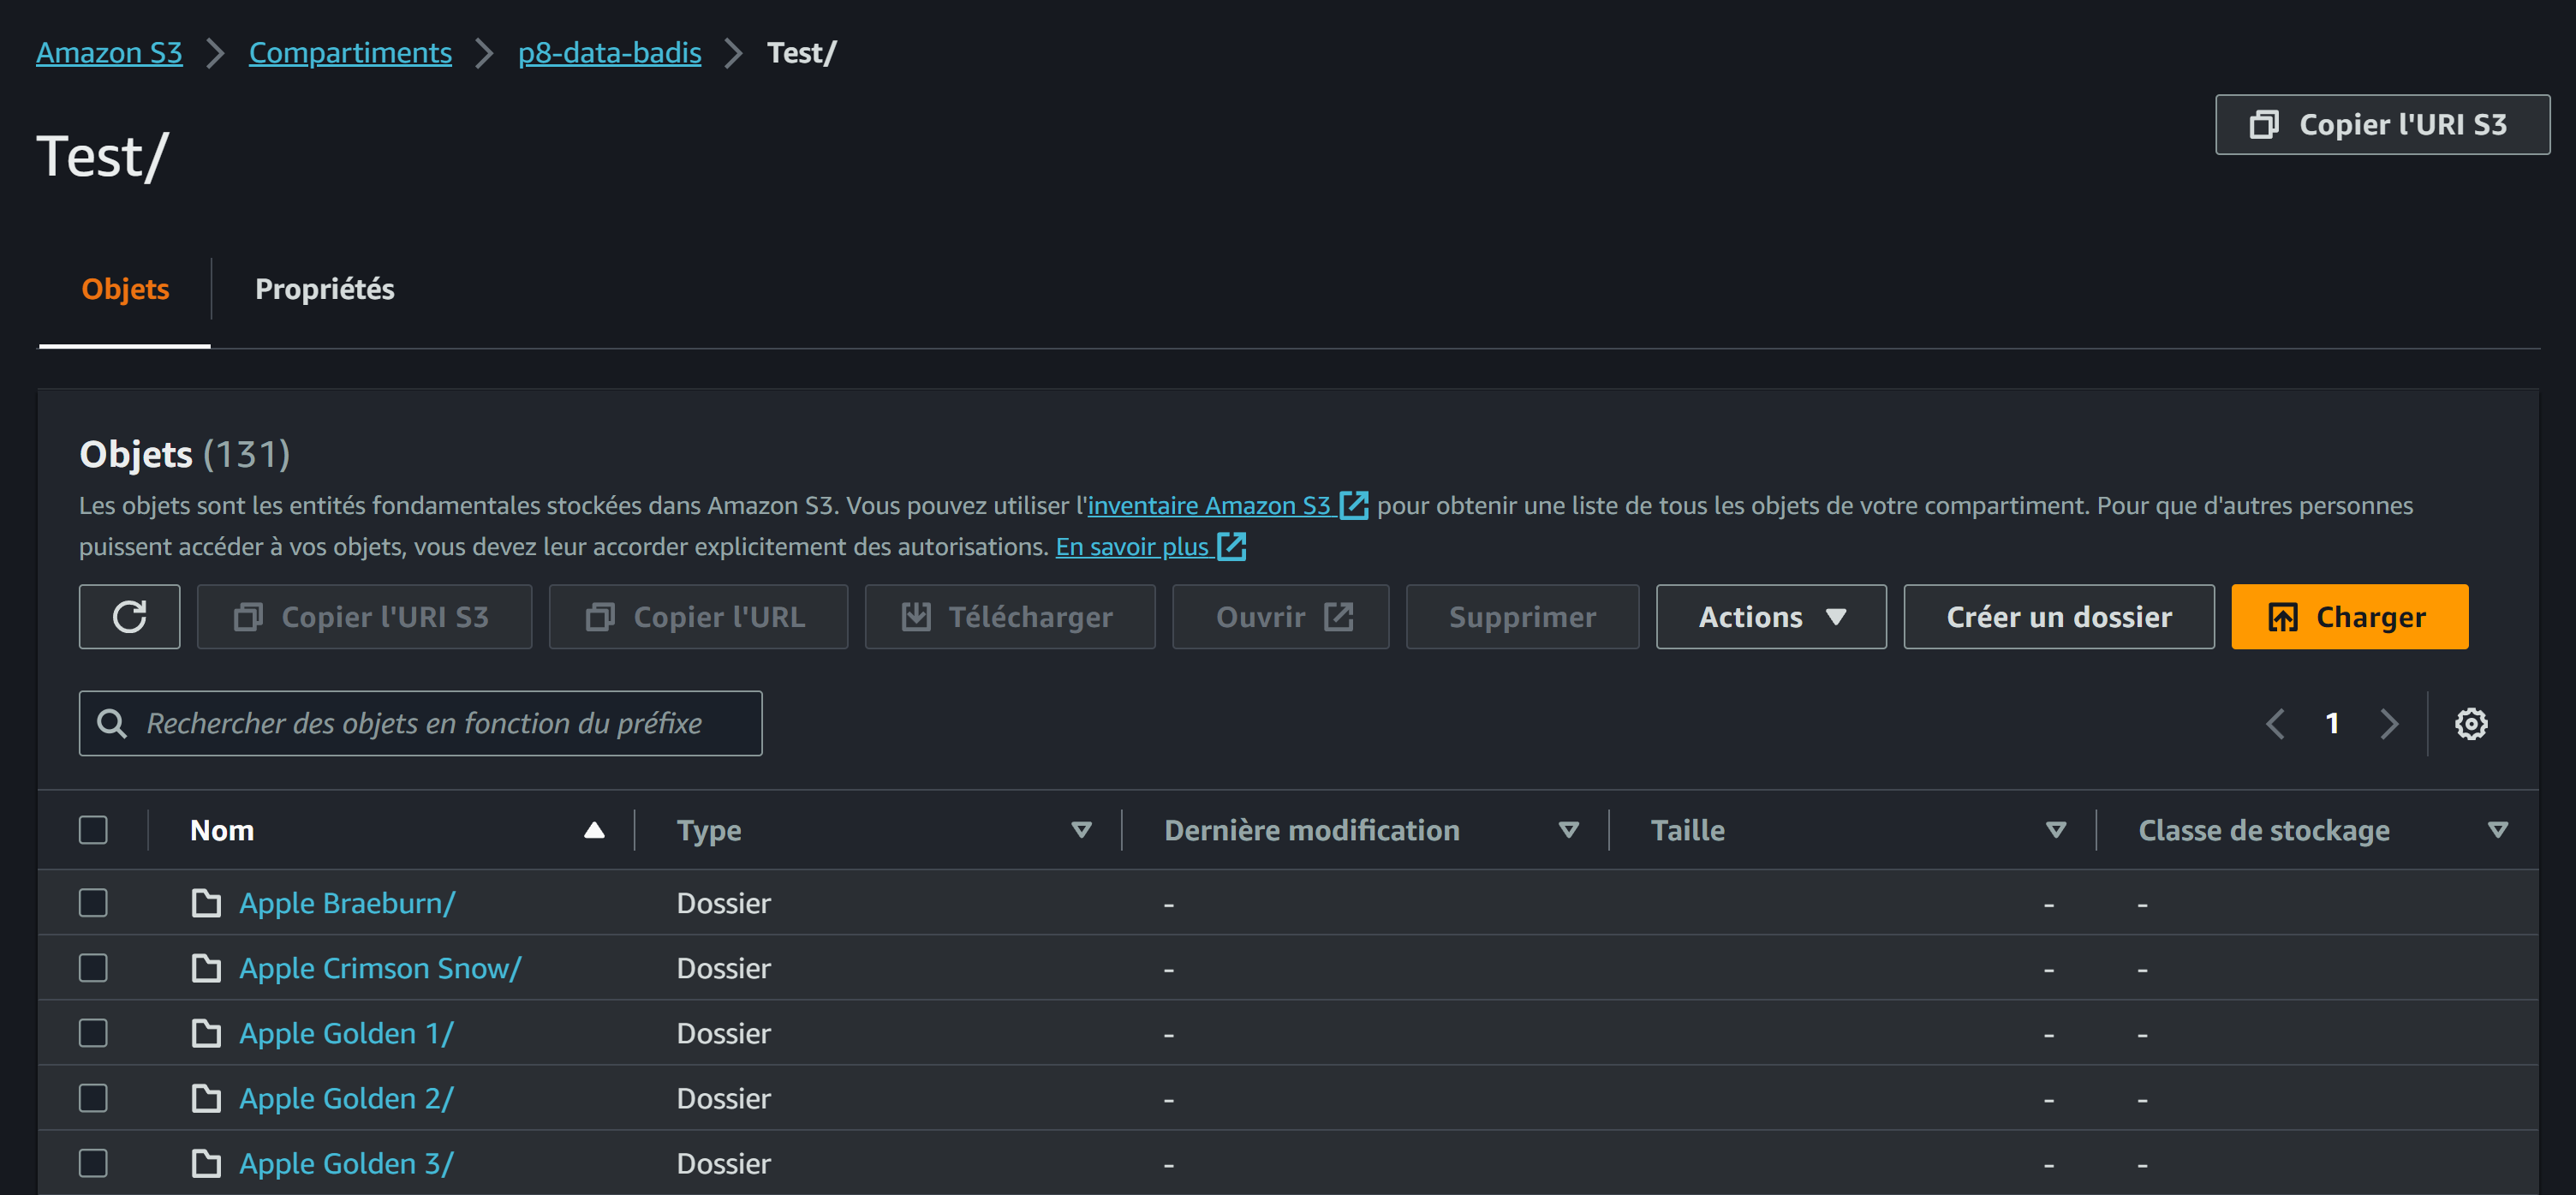

## Etape #8: Création clés SSH

**Elles sont éssentiels pour lancer une machine EMR (qui se repose sur les machines EC2)**  
EC2 -> Paires de clés -> Créer une paire de clés

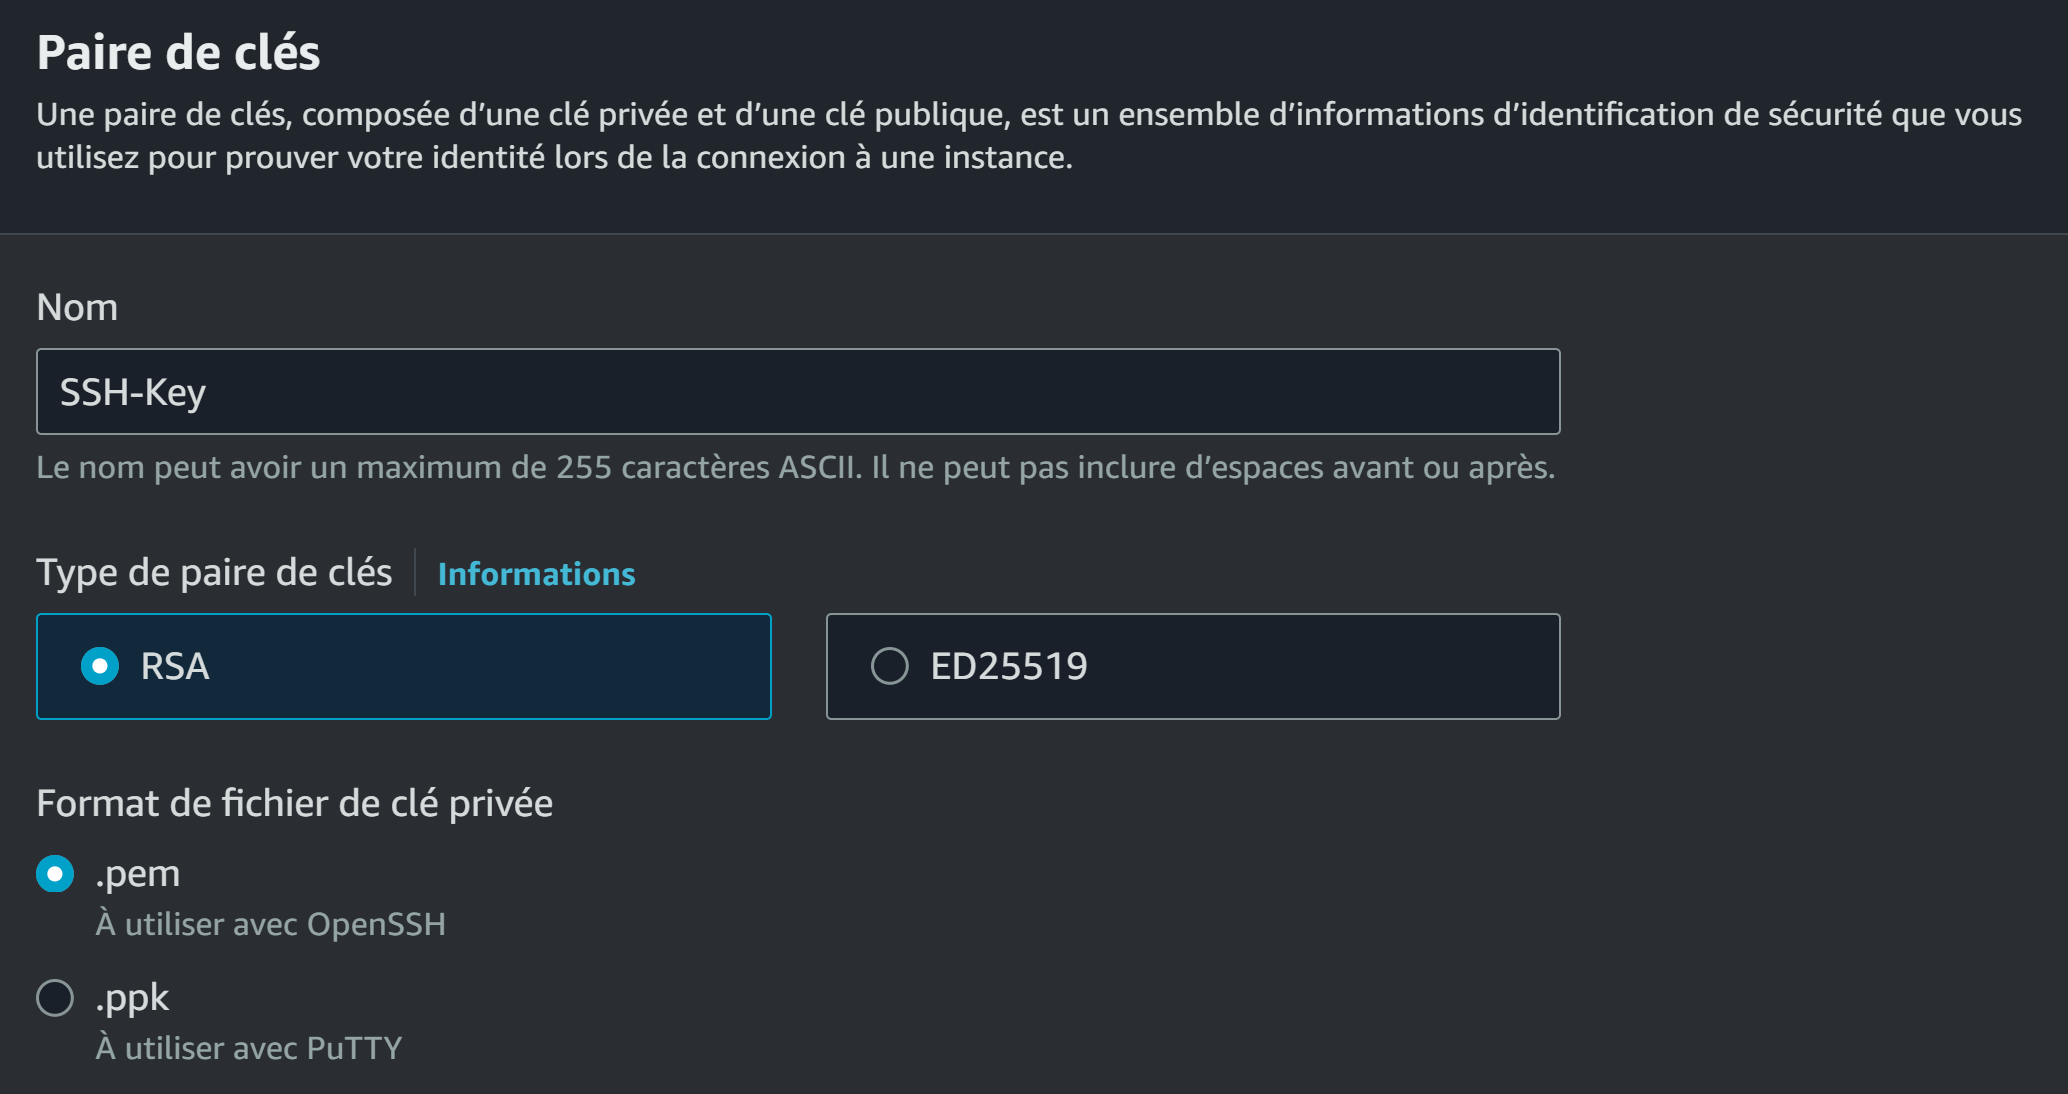

- **RSA:** Recommandé pour une compatibilité maximale
- **.pem:** OpenSSH est a choisir car compatible avec linux

## Etape #9: Ajouter la clé SSH dans \home\NomUtilisateur

Sinon la connection avec le cluster ne marchera pas 

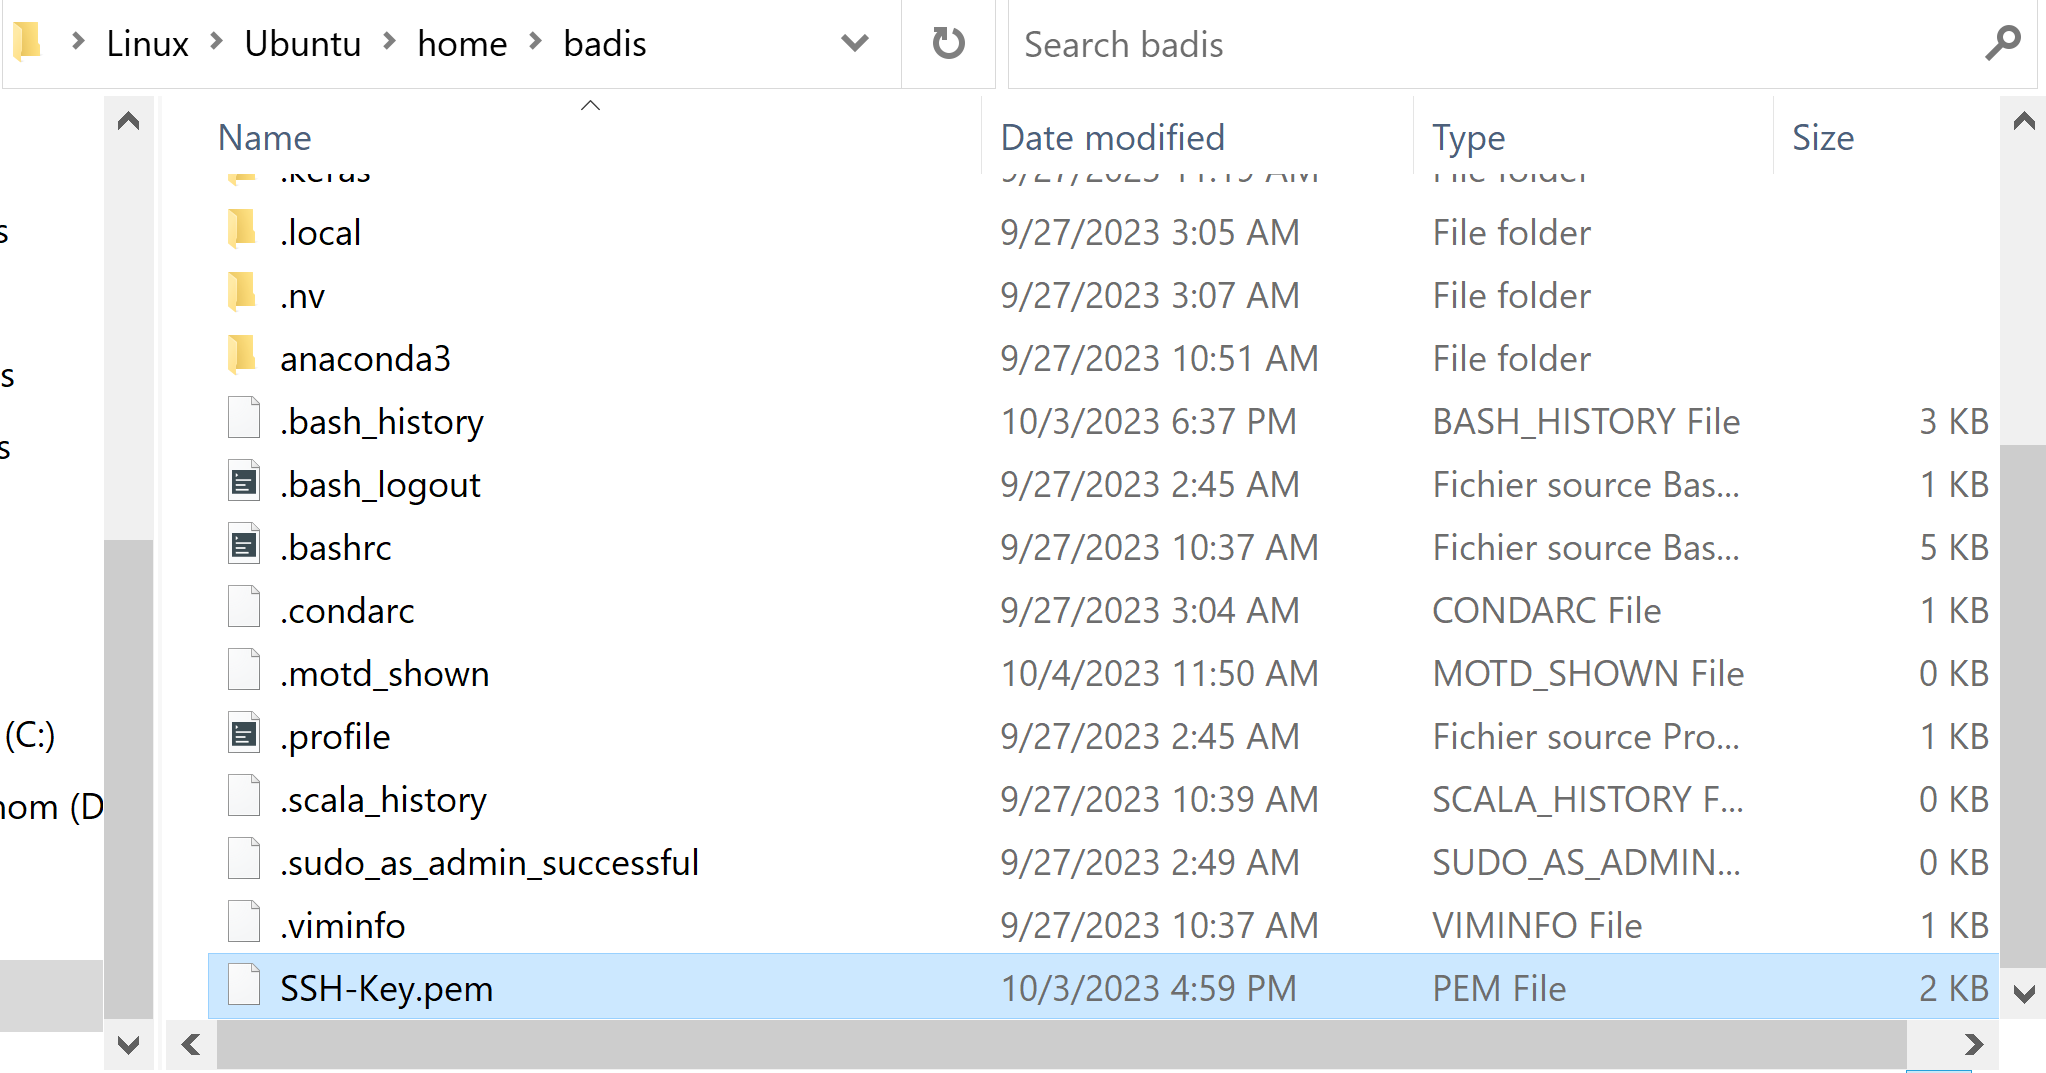

## Etape #10: Ajouter sécurité sur la clé SSH

**Sinon on aura l'érreur suivante:**  
*Permissions 0644 for '/home/badis/SSH-Key.pem' are too open.
It is required that your private key files are NOT accessible by others.*

In [3]:
!chmod 600 /home/badis/SSH-Key.pem

## Etape #11: Autoriser le tunnel SSH dans AWS

**On doit pouvoir utiliser JupyterHub et les logs de Spark directement dans notre machine:**
- Le souci étant qu'ils sont dans le réseau local du driver
- Nous devons créer un tunel SSH vers ce driver avec le port 22
- Le souci étant que le firewall d'AWS bloque ce port
- Nous devons l'autoriser

- EC2 -> Groupes de sécurité -> Cliquer sur "ElasticMapReduce-master"
- Cliquer sur "Actions" -> "Modifier les règles entrantes"
- Cliquer sur "Ajouter une règle" 2X

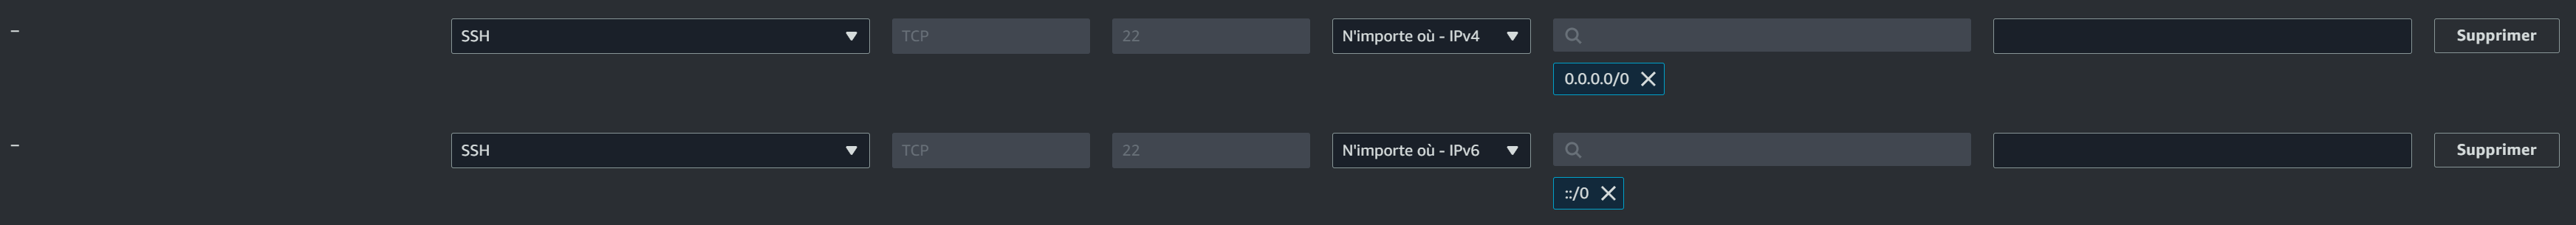

## Etape #12: Configuration du serveur EMR

**EMR -> Créer un cluster**

### 1 - Applications principales

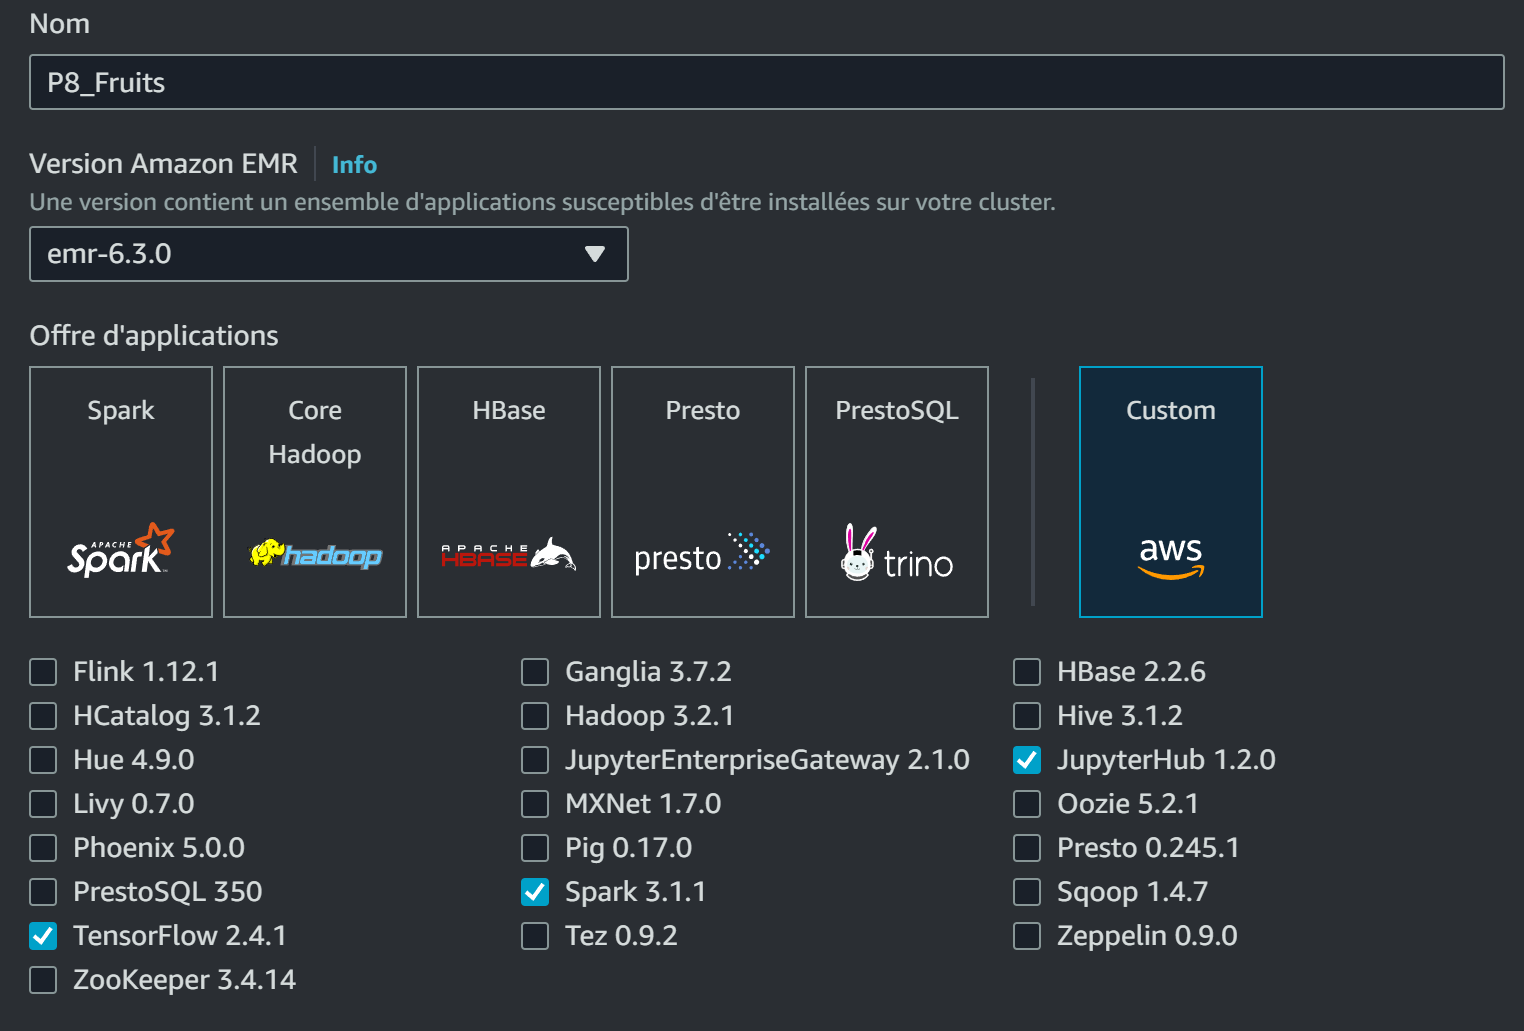

### 2 - Notebooks sur S3 uniquement

**On doit lire et enregistrer les notebooks sur S3 et non sur le disque dur EMR**  
On doit ajouter ce JSON dans la config

### 3 - Choix des machines

**Pour le choix des machines de clusters nous allons partir sur la configuration suivante:**
- Une machine Primaire
- Une unité principale
- 6 unités de tâche

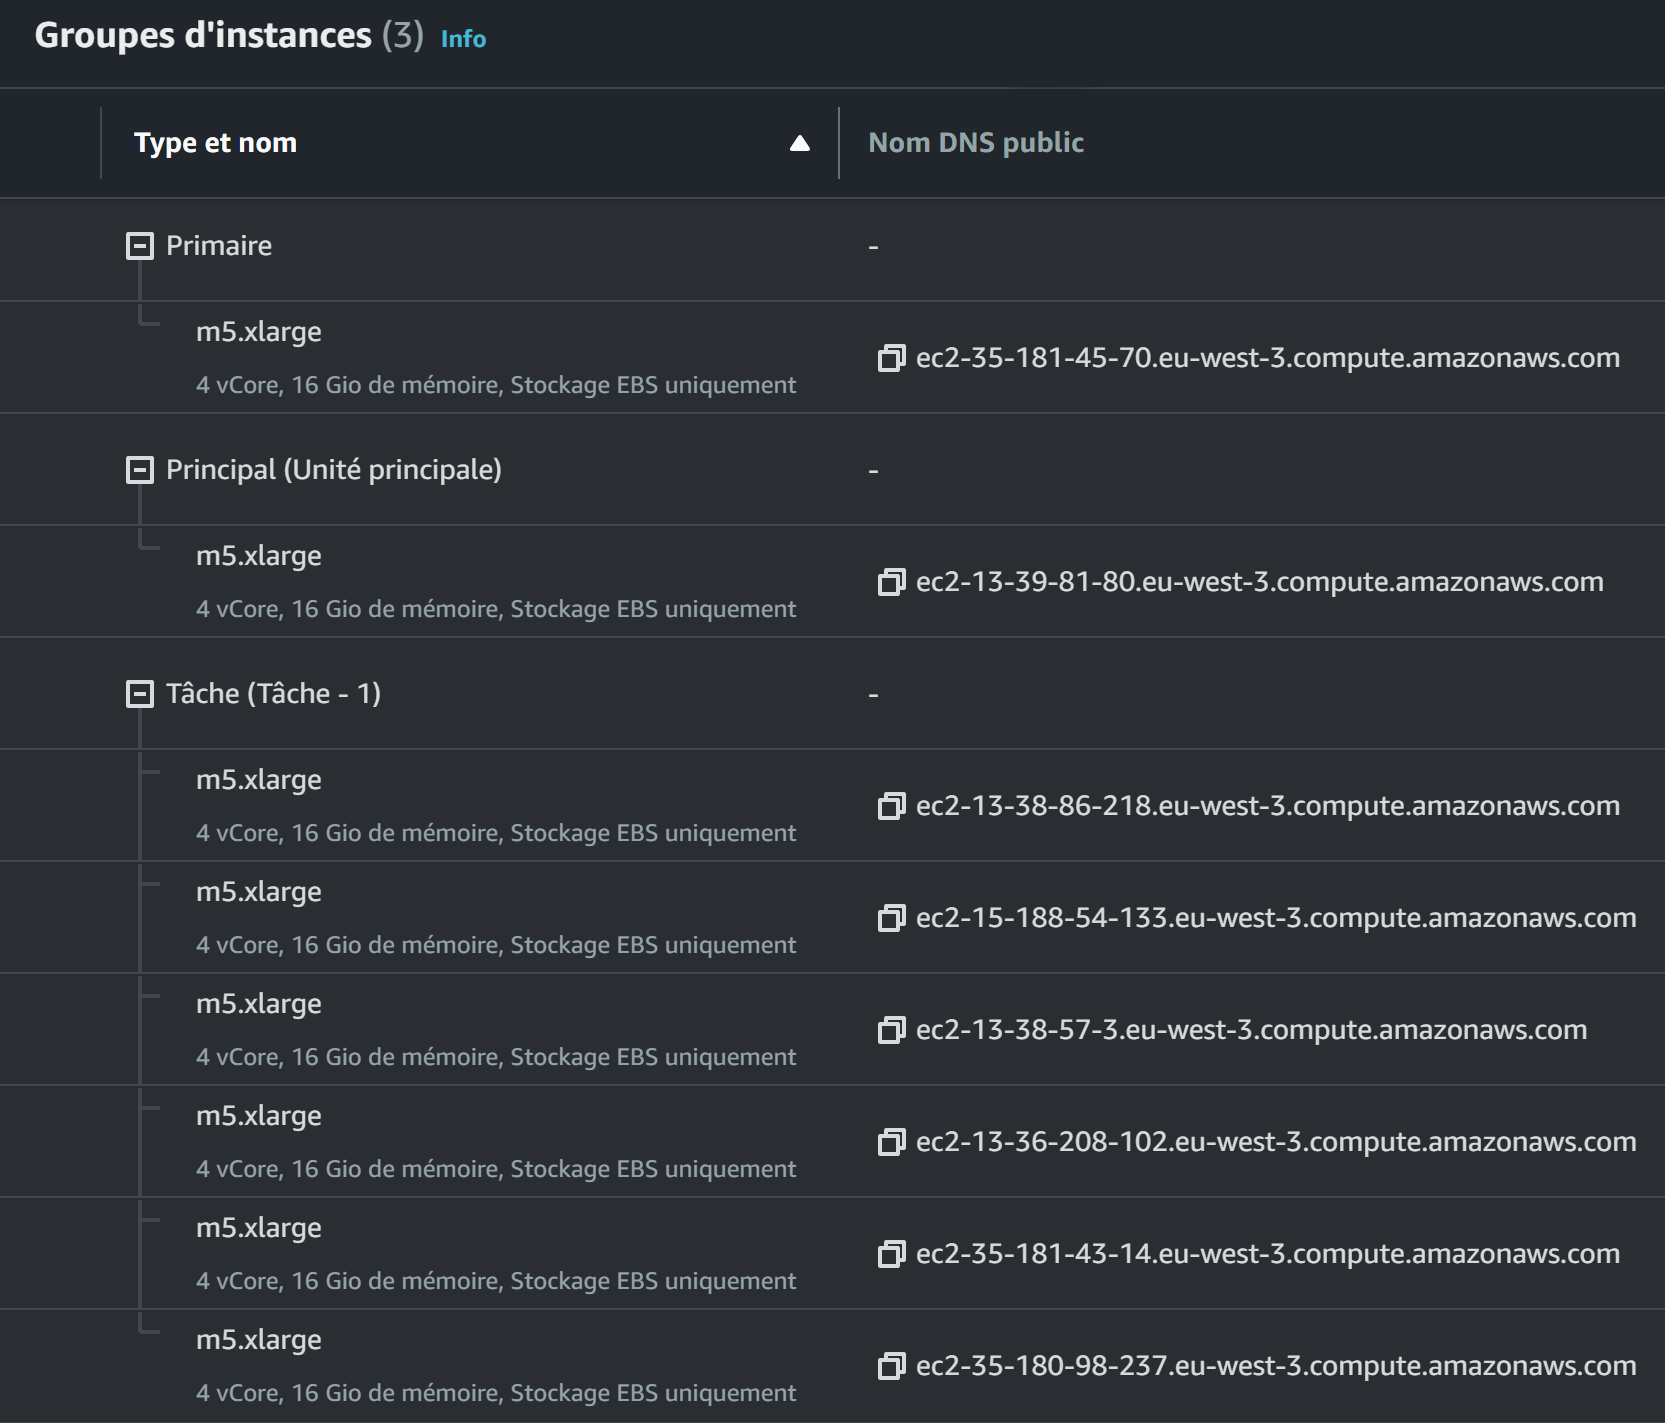

https://docs.aws.amazon.com/emr/latest/ManagementGuide/emr-master-core-task-nodes.html

**Primaire (Master):** Gère le cluster et exécute généralement les composants principaux des applications distribuées. Par exemple le service YARN ResourceManager pour gérer les ressources

**Unité principale (Core):** Ils exécutent le démon Data Node pour coordonner le stockage des données dans le cadre du système de fichiers distribué Hadoop (HDFS). Ils exécutent également le démon Task Tracker et effectuent d’autres tâches de calcul parallèle sur les données requises par les applications installées

**Tâche (Task)**: Nœuds supplémentaires qui ne stockent pas de données dans HDFS et qui sont utilisés uniquement pour effectuer des tâches de calcul

**m5.xlarge:** Instance Amazon EC2 qui offre un équilibre entre le calcul, la mémoire et les ressources réseau pour un large éventail de charges de travail

### 4 - Désactivation de la protection contre la résiliation

**On décoche "Utiliser la protection contre la résiliation"**

### 5 - Bootstrapping

**On doit installer d'autres packages (qui ne sont pas dans les machines de base) pour que le calcul puisse s'effectuer:**
- Le bootstrapping permet que les packages soient dans toutes les machines et pas uniquement le driver

On cré tout d'abord un fichier sh qui contiendra tout les packages nécéssaires:

- **setuptools** et **pip** sont mis à jour pour éviter une problématique avec l'installation du package **pyarrow**
- **pandas** doit avoir une version < 1.3.0 car sinon elle demande une version de **numpy** que le cluster n'a pas
- **matplotlib** doit etre de version 3.4 pour etre compatible avec la version numpy par défaut (1.16.5)


**On se met dans le dossier qui contient le fichier sh (bootstrap.sh) et on ouvre bash**  
*C:\Users\Home\Desktop\OpenClassrooms\Projet8\Projet\Bootstrapping*

**On met ce fichier à la racine du bucket s3**

**On vérifie qu'on a bien le fichier .sh dans le bucket**

In [1]:
!aws s3 ls s3://p8-data-badis

                           PRE Test/
2023-10-03 18:12:35        346 bootstrap.sh


**Actions d'amorcage -> Cliquer sur "Ajouter"**

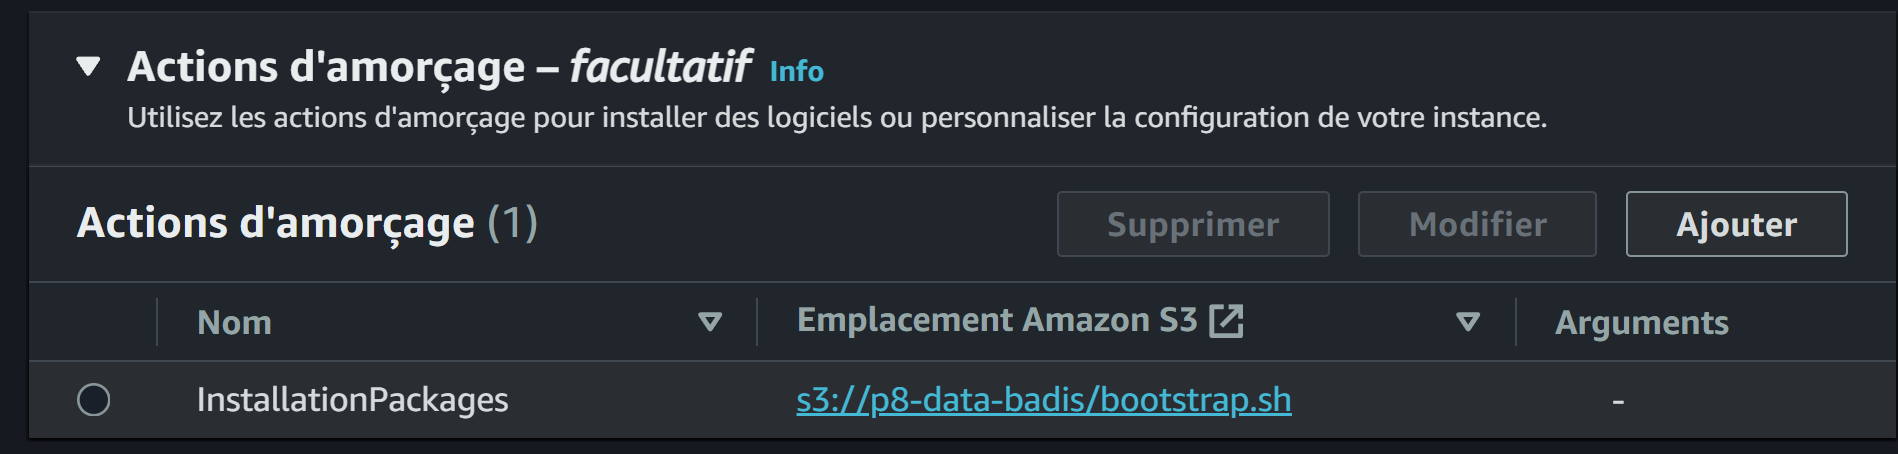

### 6 - Ajout de la paire de clé SSH

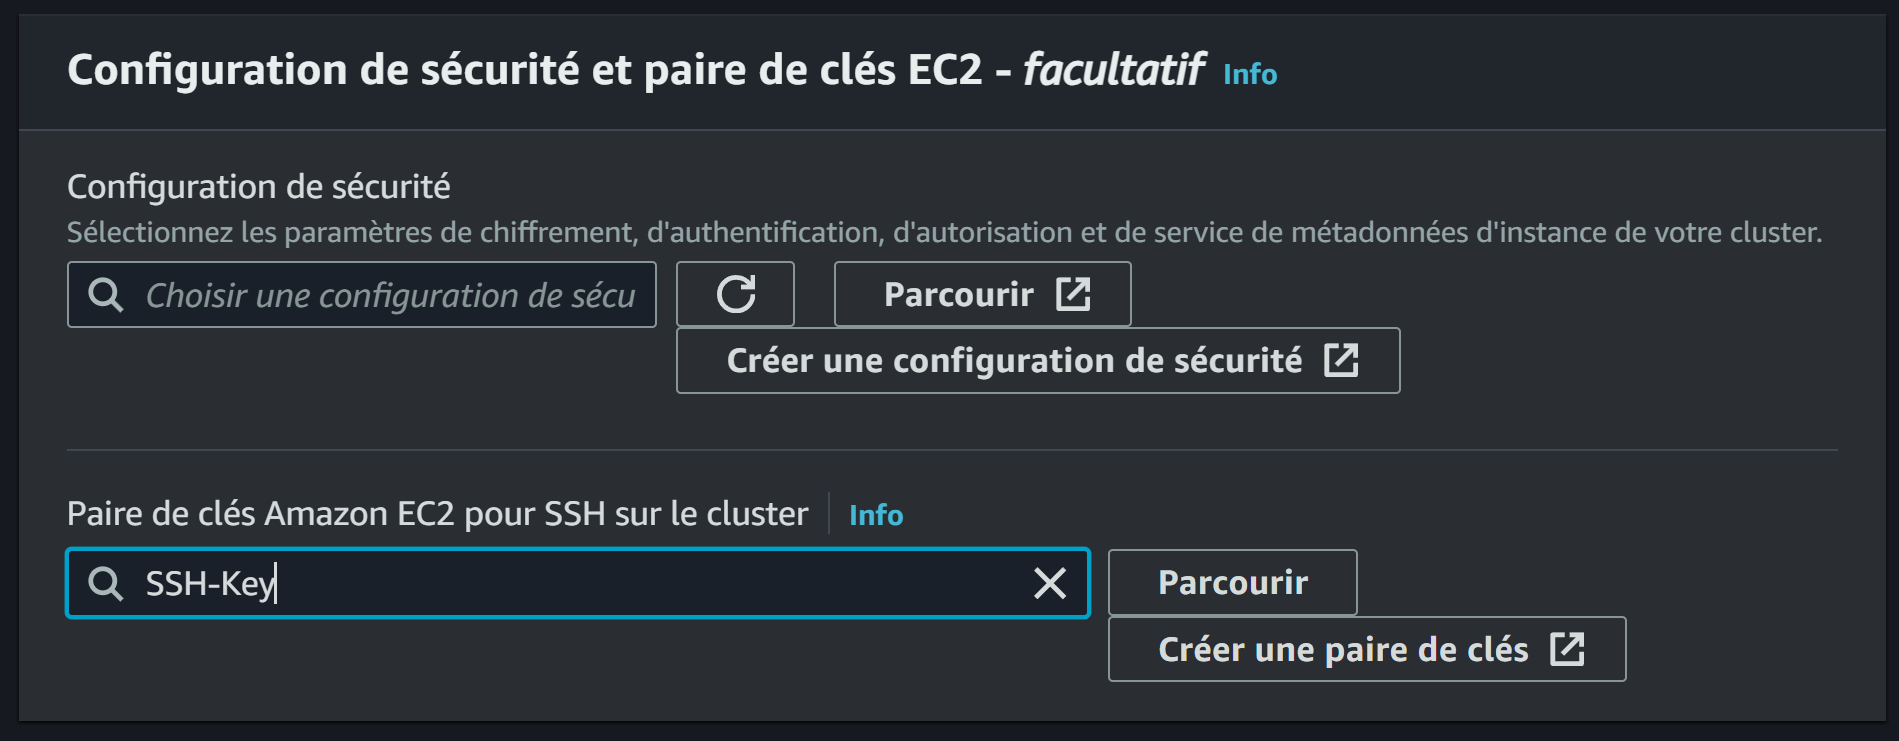

### 7 - Autoriser tout nos buckets de S3

Sinon le cluster ne pourra pas acceder à nos données

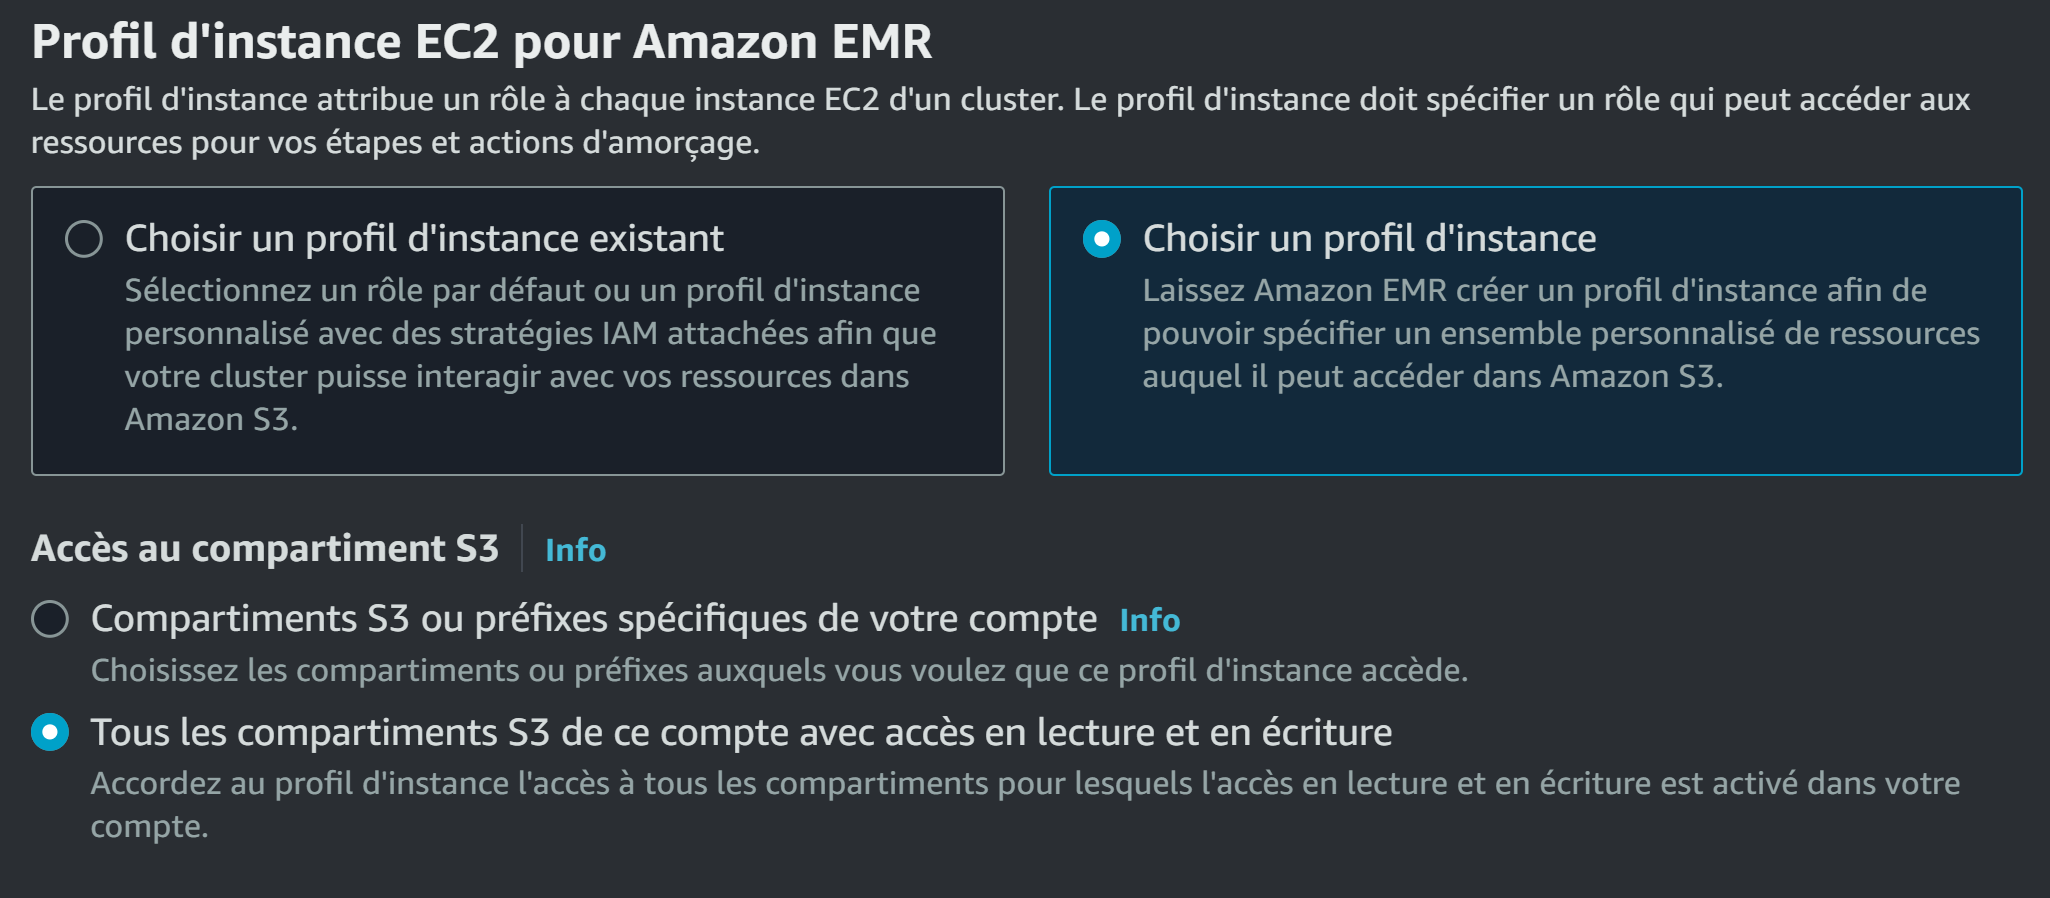

**On peut maintenant lancer le cluster**

## Etape #13: Etablir le tunnel SSH avec le cluster

Une fois que le serveur est en train de tourner:
- Cliquer sur "Connexion au nœud primaire à l'aide de SSH"
- On récupère le lien qu'il nous propose (à utiliser sur bash surtout)
- Si on veut prendre un autre port que le 22, on ajoute "-D 8157" par exemple

## Etape #14: Permettre à notre navigateur d'utiliser le tunnel SSH

**J'utilise chrome -> Extension FoxyProxy**

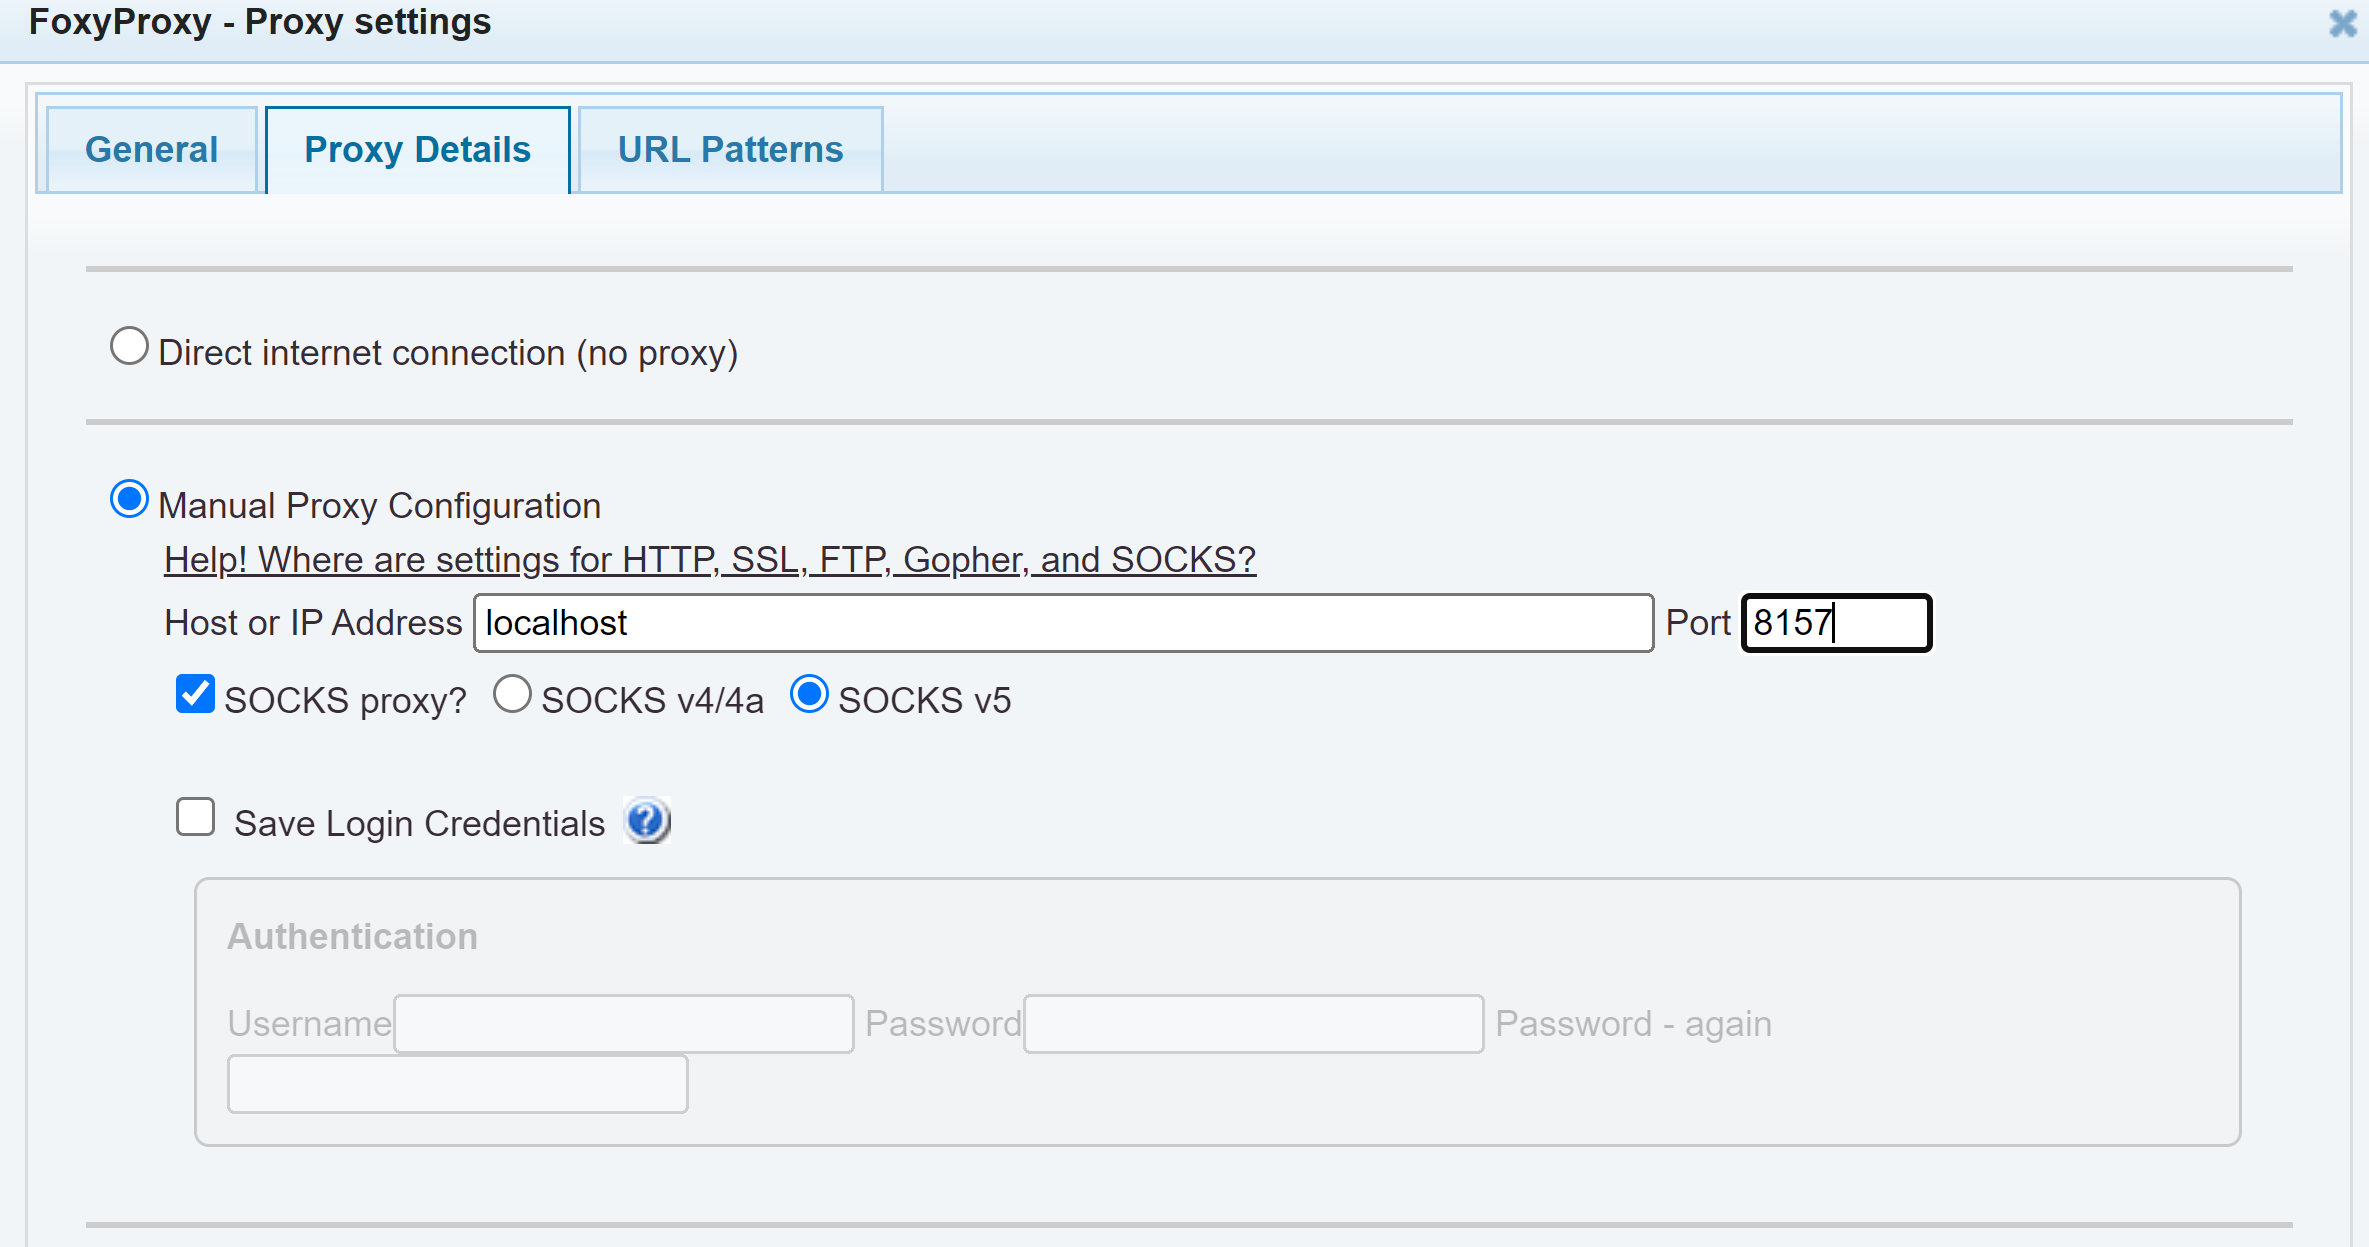

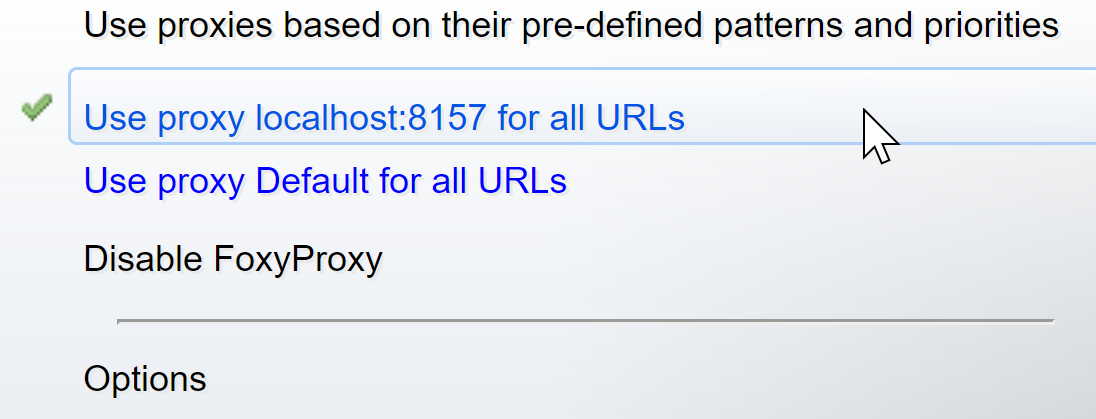

## Etape #15: Acceder au notebook JupyterHub

Dans l'onglet "Applications" nous pouvons désormais acceder à toutes les applications qui nous intéresse

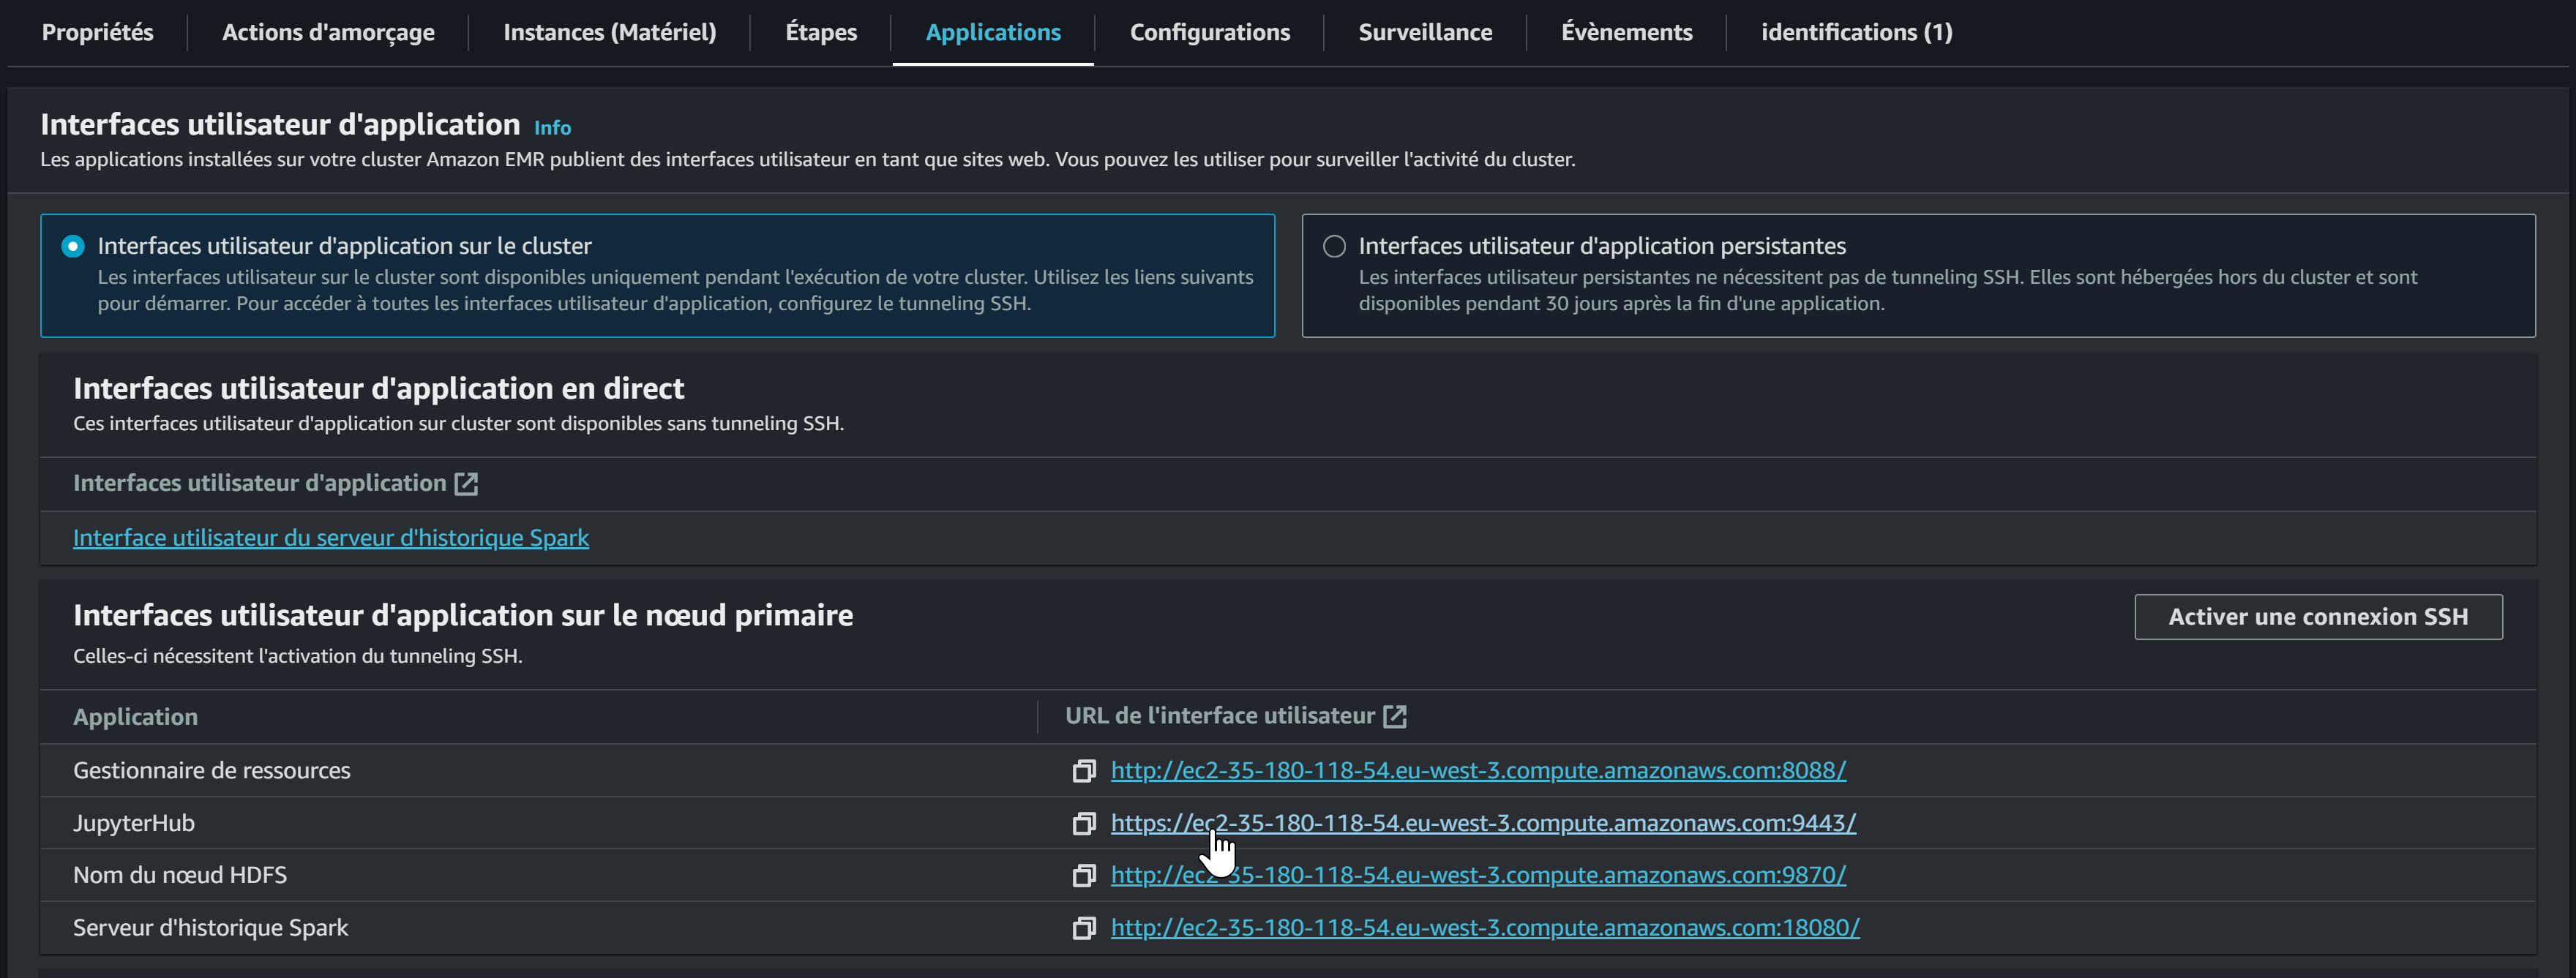

**Le login et le password sont toujours les mêmes pour jupyterHub:**
- login: jovyan
- password: jupyter

# Script PySpark (cloud)

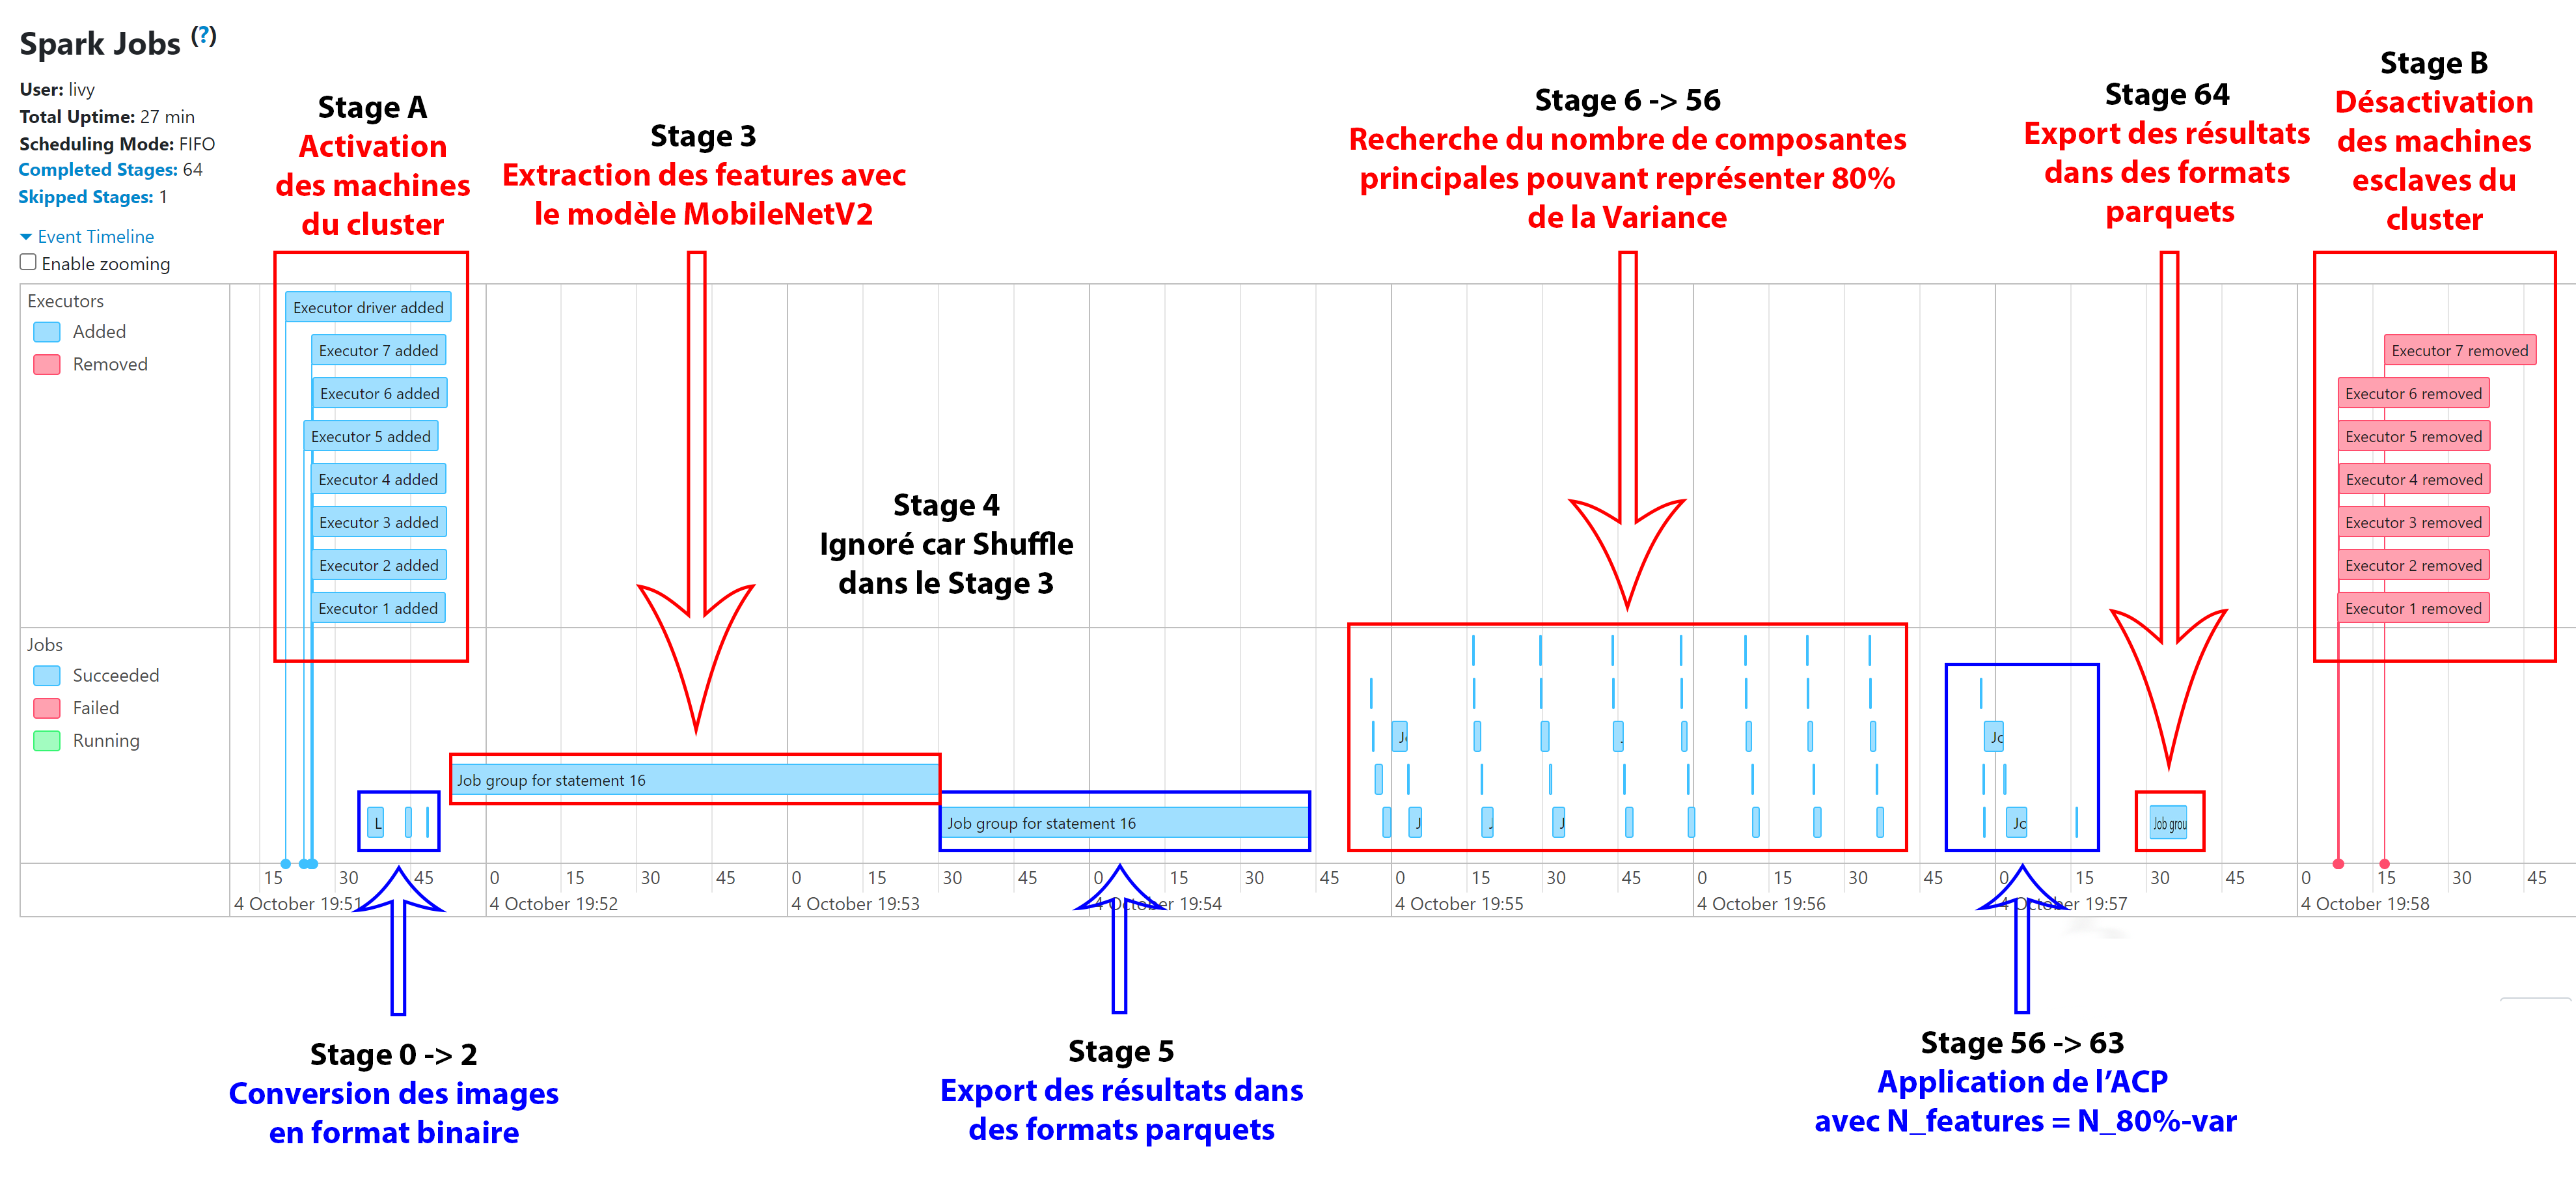

## Configurations PySpark

In [28]:
%%info

In [29]:
import pandas as pd
import numpy as np
import io
import os
import tensorflow as tf
from PIL import Image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Stage 0 -> 2 : Conversion des images en format binaire

In [3]:
PATH = 's3://p8-data-badis'
PATH_Data = PATH+'/Test'
PATH_Result = PATH+'/Results'
print('PATH:        '+\
      PATH+'\nPATH_Data:   '+\
      PATH_Data+'\nPATH_Result: '+PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

PATH:        s3://p8-data-badis
PATH_Data:   s3://p8-data-badis/Test
PATH_Result: s3://p8-data-badis/Results

In [4]:
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
images.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|s3://p8-data-badi...|2023-10-03 14:29:05|  7353|[FF D8 FF E0 00 1...|
|s3://p8-data-badi...|2023-10-03 14:29:06|  7350|[FF D8 FF E0 00 1...|
|s3://p8-data-badi...|2023-10-03 14:29:06|  7349|[FF D8 FF E0 00 1...|
|s3://p8-data-badi...|2023-10-03 14:29:05|  7348|[FF D8 FF E0 00 1...|
|s3://p8-data-badi...|2023-10-03 14:29:06|  7328|[FF D8 FF E0 00 1...|
+--------------------+-------------------+------+--------------------+
only showing top 5 rows

In [6]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+------------------------------------------------+----------+
|path                                            |label     |
+------------------------------------------------+----------+
|s3://p8-data-badis/Test/Watermelon/r_106_100.jpg|Watermelon|
|s3://p8-data-badis/Test/Watermelon/r_109_100.jpg|Watermelon|
|s3://p8-data-badis/Test/Watermelon/r_108_100.jpg|Watermelon|
|s3://p8-data-badis/Test/Watermelon/r_107_100.jpg|Watermelon|
|s3://p8-data-badis/Test/Watermelon/r_95_100.jpg |Watermelon|
+------------------------------------------------+----------+
only showing top 5 rows

None

## Stage 3 : Extraction des features avec le modèle MobileNetV2

In [7]:
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
new_model.summary()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [10]:
brodcast_weights = sc.broadcast(new_model.get_weights())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
from pyspark.sql.pandas.functions import pandas_udf
from typing import Iterator, Tuple
import pandas as pd

@pandas_udf("array<float>")
def featurize_udf(content_series_iter: Iterator[pd.Series]) -> Iterator[pd.Series]:
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
features_df = images.sample(False, 1.0).repartition(20).select(col("path"),
                                                               col("label"),
                                                               featurize_udf("content").alias("features")
                                                              )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
print(PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

s3://p8-data-badis/Results

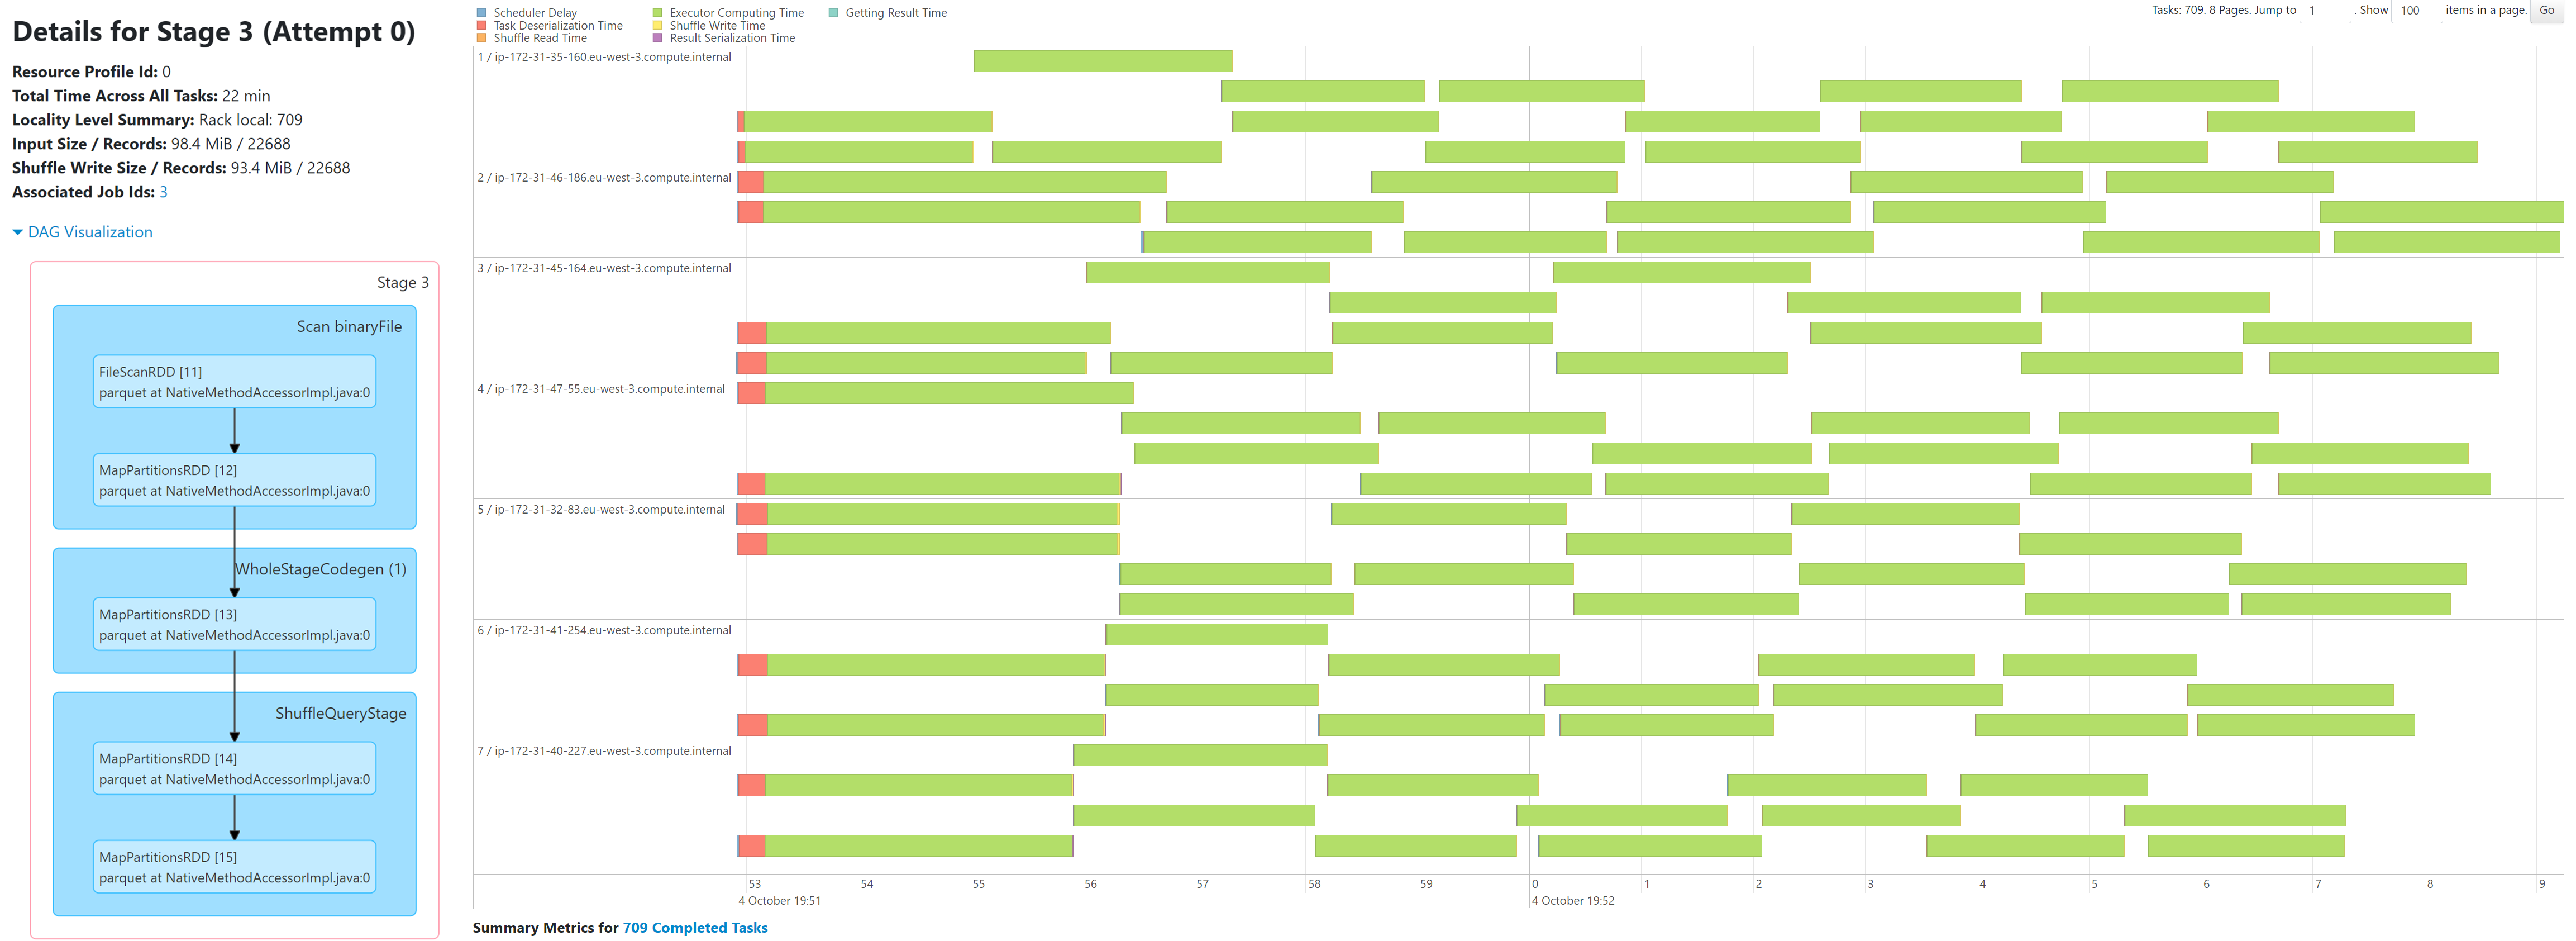

## Stage 5 : Export des résultats dans des formats parquets

In [17]:
features_df.write.mode("overwrite").parquet(PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Importation des formats parquets sous forme d'un dataframe "classique"

In [18]:
df = pd.read_parquet(PATH_Result, engine='pyarrow')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
df.loc[0,'features'].shape

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(1280,)

In [20]:
df = df.sample(frac=0.5, random_state=42)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Stage 6 -> 56 : Recherche du nombre de composantes principales pouvant représenter 80% de la Variance

In [21]:
df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                                    path  ...                                           features
15255          s3://p8-data-badis/Test/Walnut/84_100.jpg  ...  [0.0, 0.10768058, 0.0, 0.0, 1.0147971, 0.0, 2....
6119          s3://p8-data-badis/Test/Peach 2/80_100.jpg  ...  [0.3118744, 0.25664043, 0.0, 0.0, 0.3285394, 0...
3519          s3://p8-data-badis/Test/Apricot/58_100.jpg  ...  [0.27679244, 0.51053095, 0.0, 0.0010203512, 0....
10281            s3://p8-data-badis/Test/Fig/195_100.jpg  ...  [0.044422902, 0.16767748, 0.0, 0.0, 0.7941373,...
13469       s3://p8-data-badis/Test/Nectarine/46_100.jpg  ...  [0.6690598, 0.0, 0.0015474737, 0.0, 0.0, 0.0, ...
...                                                  ...  ...                                                ...
4513      s3://p8-data-badis/Test/Chestnut/r2_10_100.jpg  ...  [1.1293542, 0.0, 0.0, 0.0, 0.0019373585, 0.907...
20848       s3://p8-data-badis/Test/Mangostan/46_100.jpg  ...  [0.2399836, 0.10692097, 0.0033696

In [22]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import PCA
from pyspark.sql.functions import udf

spark.sparkContext.setLogLevel("ERROR")

# Conversion du DataFrame Pandas en DataFrame PySpark
df['features'] = df['features'].apply(lambda x: Vectors.dense(x))
df_spark = spark.createDataFrame(df)

# Création d'un VectorAssembler qui combine une liste de colonnes en une seule colonne de vecteur.
vecAssembler = VectorAssembler(inputCols=["features"], outputCol="features_vec")

# Utilisation du VectorAssembler pour transformer notre DataFrame.
df_spark = vecAssembler.transform(df_spark)

variances = []
total_features = len(df_spark.select("features").first()[0])
step_size = int(total_features * 0.01) # 1% du nombre total de caractéristiques
# Initialisation de la liste des résultats
resultats = []
resultats.append(((0, 0.0)))
print(resultats)
for k in range(1, total_features + 1, step_size):
    # Création d'une instance de PCA qui prend en entrée la colonne "features_vec" et renvoie la colonne "pcaFeatures".
    pca = PCA(k=k, inputCol="features_vec", outputCol="pcaFeatures")
    
    # Entraînement du modèle PCA.
    model = pca.fit(df_spark)
    
    # Ajout de la variance expliquée au tableau des variances.
    explained_variance = sum(model.explainedVariance)
    variances.append(explained_variance)

    # Ajout du nombre de caractéristiques et de la variance expliquée à la liste des résultats
    resultats.append((k, explained_variance))

    # Si la variance expliquée est égale à 1, arrêtez la boucle.
    if explained_variance >= 0.8:
        break

resultats.append(((total_features, 1.0)))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[(0, 0.0)]

In [23]:
resultats

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[(0, 0.0), (1, 0.09947919535315272), (13, 0.4941852403348042), (25, 0.6155715001501709), (37, 0.6836967064735735), (49, 0.7290726977121523), (61, 0.7633038399035622), (73, 0.7897934475084364), (85, 0.810708637184719), (1280, 1.0)]

## Affichage de l'explication de la variance et print de Nb_composants_80

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import math

# Séparation des données en deux listes pour les axes x et y
x_data = [i[0] for i in resultats]
y_data = [i[1]*100 for i in resultats]

# Création du graphe
plt.figure(figsize=(10,6))
plt.plot(x_data, y_data, marker='o', label='Variance expliquée')

# Ajout des titres et labels
plt.title('Explication de la variance en fonction du Nb de composantes principales')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Explication de la variance (%)')

# Trouver la valeur x pour laquelle y atteint 80%
x_80 = np.interp(80, y_data, np.round(x_data))

# Tracer une ligne verticale à cette position x
plt.axvline(x=x_80, color='g', label='80% de variance expliquée')

# Ajouter la valeur de x en dessous du trait vertical
plt.text(x_80+30, 7, f'{math.ceil(x_80)}', color='g', ha='center')

# Afficher la légende
plt.legend()

# Affichage du graphe
plt.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

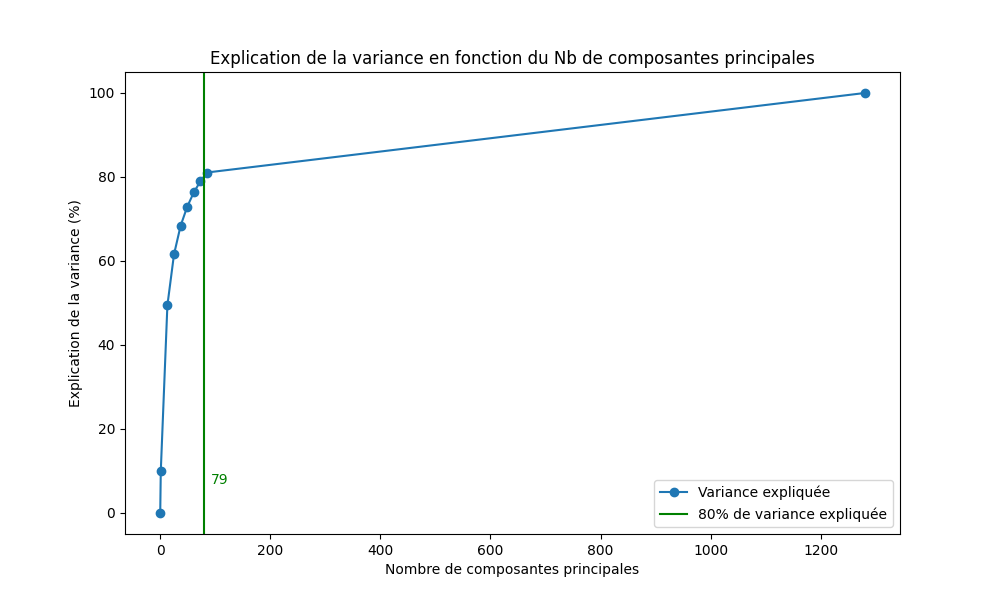

In [25]:
%matplot plt

In [26]:
Nb_composants_80 = math.ceil(x_80)
Nb_composants_80

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

79

## Stage 57 -> 63 : Application de l’ACP avec N_features = N_80%-var

In [27]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

spark.sparkContext.setLogLevel("ERROR")

# Conversion du DataFrame Pandas en DataFrame PySpark
df['features'] = df['features'].apply(lambda x: Vectors.dense(x))
df_spark = spark.createDataFrame(df)

# Création d'un VectorAssembler qui combine une liste de colonnes en une seule colonne de vecteur.
vecAssembler = VectorAssembler(inputCols=["features"], outputCol="features_vec")

# Utilisation du VectorAssembler pour transformer notre DataFrame.
df_spark = vecAssembler.transform(df_spark)

# Création d'un objet PCA 
pca = PCA(k=Nb_composants_80, inputCol="features_vec", outputCol="pcaFeatures")

# Entraînement du modèle PCA sur les données
model = pca.fit(df_spark)

# Transformation des données avec le modèle PCA
result = model.transform(df_spark)

# Suppression de la colonne 'features_vec'
result = result.drop('features_vec')

# Affichage des résultats
result.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+--------------------+--------------------+
|                path|             label|            features|         pcaFeatures|
+--------------------+------------------+--------------------+--------------------+
|s3://p8-data-badi...|            Walnut|[0.0,0.1076805815...|[-3.6482864877990...|
|s3://p8-data-badi...|           Peach 2|[0.31187438964843...|[5.02625114165588...|
|s3://p8-data-badi...|           Apricot|[0.27679243683815...|[7.43810529414139...|
|s3://p8-data-badi...|               Fig|[0.04442290216684...|[1.60496671402057...|
|s3://p8-data-badi...|         Nectarine|[0.66905981302261...|[8.09640792075932...|
|s3://p8-data-badi...|        Grape Blue|[0.00959786493331...|[8.02054488122425...|
|s3://p8-data-badi...|Apple Red Yellow 1|[0.02418400160968...|[1.87611586230161...|
|s3://p8-data-badi...|       Apple Red 2|[0.52969521284103...|[4.76299072587483...|
|s3://p8-data-badi...|     Tomato Maroon|[0.46315145492553...|[8.93877183752

In [2]:
PATH = 's3://p8-data-badis'
PATH_Data = PATH+'/Test'
PATH_Result_PCA = PATH+'/Results_PCA'
print('PATH:        '+\
      PATH+'\nPATH_Data:   '+\
      PATH_Data+'\nPATH_Results_PCA: '+PATH_Result_PCA)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

PATH:        s3://p8-data-badis
PATH_Data:   s3://p8-data-badis/Test
PATH_Results_PCA: s3://p8-data-badis/Results_PCA

In [12]:
from pyspark.sql.functions import udf
from pyspark.ml.linalg import VectorUDT, DenseVector
from pyspark.sql.types import ArrayType, FloatType

# UDF pour convertir Vector en list
vector_to_list = udf(lambda v: v.toArray().tolist(), ArrayType(FloatType()))

# Appliquer la conversion
result = result.withColumn("features", vector_to_list(result["features"]))
result = result.withColumn("pcaFeatures", vector_to_list(result["pcaFeatures"]))

# Écrire dans Parquet
result.write.mode('overwrite').parquet(PATH_Result_PCA)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
df = pd.read_parquet(PATH_Result_PCA, engine='pyarrow')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                                    path  ...                                        pcaFeatures
0              s3://p8-data-badis/Test/Walnut/84_100.jpg  ...  [-3.6482866, 6.467171, -11.337626, -7.5191717,...
1             s3://p8-data-badis/Test/Peach 2/80_100.jpg  ...  [5.0262513, -4.0308876, -3.4864435, 0.20136726...
2             s3://p8-data-badis/Test/Apricot/58_100.jpg  ...  [7.438105, -3.4315648, -5.752143, -4.6523128, ...
3                s3://p8-data-badis/Test/Fig/195_100.jpg  ...  [1.6049668, 2.9308999, -3.6567686, -8.997009, ...
4           s3://p8-data-badis/Test/Nectarine/46_100.jpg  ...  [8.096408, 0.10162783, -6.590019, -14.400669, ...
...                                                  ...  ...                                                ...
11339     s3://p8-data-badis/Test/Chestnut/r2_10_100.jpg  ...  [-2.8889272, 7.202672, -9.034046, -10.2222395,...
11340       s3://p8-data-badis/Test/Mangostan/46_100.jpg  ...  [2.2601643, 5.282809, -8.180792, 